In [1]:
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import numpy as np

/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-01 16:39:49,245	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Dataloader requests:
* Ask for dlst codes and rets in crsp data loader
* Ask for compustat in data loader
* Ask for someone to fix crsp data loader bc it is not on grpquant

Problems
- We do not have the same data as CHS
- Our target is not exactly same measure as theirs
- Our hi-prob of failure stocks perform too well

### Loading in data

CRSP

In [2]:
crsp_pricing = pl.read_csv(
    r"/home/porter77/sf_fall_2025/sf-quant-labs/crsp_pricing.csv",
    infer_schema_length=10000,
    schema_overrides={
        "CUSIP": pl.Utf8,
        "NCUSIP": pl.Utf8
    }
)

crsp_delisting = pl.read_csv(
    r"/home/porter77/sf_fall_2025/sf-quant-labs/crsp_delisting.csv",
    infer_schema_length=10000,
    schema_overrides={
        "CUSIP": pl.Utf8,
        "NCUSIP": pl.Utf8
    }
)

crsp=crsp_pricing.join(crsp_delisting,on=['date','PERMNO','CUSIP'])

COMPUSTAT

In [3]:
compustat = pl.read_csv(
    r'/home/porter77/sf_fall_2025/sf-quant-labs/compustat_updated.csv',
    infer_schema_length=10000,
    schema_overrides={
        "GVKEY": pl.Utf8,
        "CUSIP": pl.Utf8,
        "TIC": pl.Utf8,
        "CONM": pl.Utf8
    }
)
#get the compustat to crsp link
link=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/link.csv')

link=link.rename({'LPERMNO':'PERMNO','GVKEY':'gvkey'})
compustat=compustat.join(link,on=['gvkey','cusip'])
compustat=compustat.rename({'datadate':'date'})


In [4]:
#merge compustat and crsp
data=crsp.join(compustat,on=['PERMNO','date'],how='left')

Get SP500 data for Size for exret factors in logit

- SP500 RET
- SP MKT CAP

In [5]:
#get 
sp500=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/sp500.csv')

sp500 = sp500.with_columns(
    pl.col("caldt").str.strptime(pl.Date, format="%Y-%m-%d").alias("caldt_date")
)

# 2. Create a "date" column set to the month-end
sp500 = sp500.with_columns(
    pl.col("caldt_date").dt.month_end().alias("date")
)
sp500

caldt,totval,totcnt,usdval,spindx,sprtrn,caldt_date,date
str,f64,i64,f64,f64,f64,date,date
"""1965-01-29""",3.95720841e8,500,3.82744572e8,87.56,0.033156,1965-01-29,1965-01-31
"""1965-02-26""",3.9533372e8,500,3.95650685e8,87.43,-0.001485,1965-02-26,1965-02-28
"""1965-03-31""",3.90352723e8,500,3.95771034e8,86.16,-0.014526,1965-03-31,1965-03-31
"""1965-04-30""",4.04184764e8,500,3.90352723e8,89.11,0.034239,1965-04-30,1965-04-30
"""1965-05-28""",4.00798168e8,500,4.04184764e8,88.42,-0.007743,1965-05-28,1965-05-31
…,…,…,…,…,…,…,…
"""2024-08-30""",4.9375e10,503,4.8316e10,5648.4,0.022835,2024-08-30,2024-08-31
"""2024-09-30""",5.0545e10,504,4.9481e10,5762.48,0.020197,2024-09-30,2024-09-30
"""2024-10-31""",5.0033e10,503,5.0538e10,5705.45,-0.009897,2024-10-31,2024-10-31


In [6]:
#make date a dt.date so it can match with sp500
data = data.with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d").alias("date")
)

data=data.join(sp500,on='date')

### Signal Construction

#### Cleaning and Defining Vars

##### Adding Delisted return

"Because we are studying the returns to distressed stocks, it is important to handle carefully the returns to stocks that are delisted and thus disappear from the CRSP database. In many cases, CRSP reports a delisting return for the final month of the firm’s life; we have 6,481 such delisting returns in our sample and we use them where they are available. Otherwise, we use the last available full-month return in CRSP. In some cases, this effectively assumes that our portfolios sell distressed stocks at the end of the month before delisting, which imparts an upward bias to the returns on distressed-stock portfolios (Shumway (1997) and Shumway and Warther (1999)).13 We assume that the proceeds from sales of delisted stocks are reinvested in each portfolio in proportion to the weights of the remaining stocks in the portfolio. In a few cases, stocks are delisted and then re-enter the database, but we do not include these stocks in the sample after the first delisting. We treat firms that fail as equivalent to delisted firms, even if CRSP continues to report returns for these firms. That is,our portfolios sell stocks of companies that fail and we use the latest available CRSP data to calculate a final return on such stocks."

We do not restrict the crosssection of firms to include only share codes 10 and 11, as Hong, Lim, and Stein (2000) do, but we
have checked that all of our results are robust to such a restriction

In [7]:
# #filter to shrcd 10,11
# data = data.filter(pl.col("SHRCD").is_in([10, 11])).sort(["PERMNO", "date"])

#cast dlret to float
data = data.with_columns(
    (pl.col('DLRET').cast(pl.Float32,strict=False)).alias('DLRET')
)
#cast ret o float
data=data.with_columns(
    (pl.col('RET').cast(pl.Float32,strict=False)).alias('RET')
)

#use dlret for ret when no ret exists
data=data.with_columns(
    pl.when((pl.col('RET').is_null()) & (pl.col('DLRET').is_not_null()))
    .then(pl.col('DLRET'))
    .otherwise(pl.col('RET'))
    .alias('RET')
)

#multiply them to get the total return for that month
data=data.with_columns(
    pl.when((pl.col('RET').is_not_null()) & (pl.col('DLRET').is_not_null()))
    .then(
        ((pl.col('RET')+1)* (1+pl.col('DLRET')))-1

    )
    .otherwise(pl.col('RET'))
    .alias('RET')
)

##### Defining Vars

$$
\text{Total Assets (adjusted)}_{i,t} = TA_{i,t} + 0.1 \big( ME_{i,t} - BE_{i,t} \big)

$$
$$
\text{Market-to-Book}_{i,t} \;=\; \frac{\text{Market Equity}_{i,t}}{\text{Book Equity}_{i,t}}


$$


In [8]:
#we lag any accounting data by 2 months

#sort before shifting
data = data.sort(["PERMNO", "date"])


#make price always postiive
data = data.with_columns(
    pl.col("PRC").abs().alias("PRC")
)

data = data.with_columns(
    (((pl.col("seqq") + pl.col("txditcq").fill_null(0) - pl.col("pstkrq").fill_null(0))).shift(2).over('PERMNO'))
    .alias("beq")
)
data=data.with_columns(
    (pl.when(pl.col('beq')<0)
    .then(pl.lit(1/1_000_000))
    .otherwise(pl.col('beq')))
    .alias('beq')
)

#now make the market equity
data = data.with_columns(
    (pl.col("PRC") * (pl.col("SHROUT")/1000))
    .alias("meq")
)

#make M/B

data=data.with_columns(
    (pl.col('meq')/pl.col('beq')).alias('mbq')
)
#make total assets adjusted
data = data.with_columns(
    (((pl.col("atq")).shift(2).over('PERMNO')) + (0.1 * (pl.col("meq") - pl.col("beq"))))
    .alias("taq_adjusted")
)



In [9]:
# data = data.with_columns([
#     pl.col("beq").fill_null(
#         pl.col("beq").mean().over("date")
#     ).alias("beq")
# ])

# #filter out the infiinte mbq
# data = data.filter(~pl.col("mbq").is_infinite())


Make the rest of the Factors

$$
RSIZE_{i,t} = \log \left( \frac{\text{Firm Market Equity}_{i,t}}{\text{Total S\&P500 Market Value}_{t}} \right)
$$

$$
EXRET_{i,t} = \log(1+R_{i,t}) - \log(1+R_{S\&P500,t})
$$

$$
NITA_{i,t} = \frac{\text{Net Income}_{i,t}}{\text{Total Assets (adjusted)}_{i,t}}
$$

$$
TLTA_{i,t} = \frac{\text{Total Liabilities}_{i,t}}{\text{Total Assets (adjusted)}_{i,t}}
$$

$$
NIMTA_{i,t} = \frac{\text{Net Income}_{i,t}}{\text{Firm Market Equity}_{i,t} + \text{Total Liabilities}_{i,t}}
$$

$$
TLMTA_{i,t} = \frac{\text{Total Liabilities}_{i,t}}{\text{Firm Market Equity}_{i,t} + \text{Total Liabilities}_{i,t}}
$$

$$
CASHMTA_{i,t} = \frac{\text{Cash and Short Term Investments}_{i,t}}{\text{Firm Market Equity}_{i,t} + \text{Total Liabilities}_{i,t}}
$$



In [10]:

data=data.with_columns(
    ((pl.col('meq')/(pl.col('totval')/1000)).log()).alias('rsize')
)

#exret
data = data.with_columns(
    ( ((1 + pl.col("RET")).log()) - ((1 + pl.col("sprtrn")).log())).alias("exret")
)

data = data.sort(["PERMNO", "date"])
#NIMTA
data=data.with_columns(
    (((pl.col('niq')).shift(2).over('PERMNO'))/(pl.col('meq')+((pl.col('ltq')).shift(2).over('PERMNO')))).alias('nimta')
)

# i had chat write these two bc i didnt want to write it out myself
data = data.sort(["PERMNO", "date"])
#TLMTA
data = data.with_columns(
    (
        (pl.col("ltq") ).shift(2).over("PERMNO")
        / (pl.col("meq") + (pl.col("ltq")).shift(2).over("PERMNO"))
    ).alias("tlmta")
)
data = data.sort(["PERMNO", "date"])
#CSHMTA
data = data.with_columns(
    (
        (pl.col("cheq") ).shift(2).over("PERMNO")
        / (pl.col("meq") + (pl.col("ltq")).shift(2).over("PERMNO"))
    ).alias("cshmta")
)

data = data.sort(["PERMNO", "date"])
#NITA
data=data.with_columns(
   ( ((pl.col('niq')).shift(2).over("PERMNO"))
    / ((pl.col('taq_adjusted')))).alias('nita')
)

data = data.sort(["PERMNO", "date"])
#TLTA
data=data.with_columns(
    (((pl.col('ltq')).shift(2).over("PERMNO"))
    / ((pl.col('taq_adjusted')))).alias('tlta')
)

In [11]:
#fill in nita and tlta

data = data.with_columns([
    pl.col("nita").fill_null(
        pl.col("nita").mean().over("date")
    ).alias("nita"),

    pl.col("tlta").fill_null(
        pl.col("tlta").mean().over("date")
    ).alias("tlta")
])

# #fill in cshmta
# data = data.with_columns([
#     pl.col("cshmta").fill_null(
#         pl.col("cshmta").mean().over("date")
#     ).alias("cshmta")
# ])



$$
SIGMA_{i,t-1,t-3} \;=\;
\left( 252 \cdot \frac{1}{N-1} 
\sum_{k \in \{t-1, t-2, t-3\}} r_{i,k}^2 \right)^{\tfrac{1}{2}}.
$$


In [12]:
#getting sigma
crsp_daily=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/crsp_daily.csv')


#do some cleaning
crsp_daily=crsp_daily.with_columns(
    (pl.col('PRC').abs()).alias('PRC')
)
crsp_daily=crsp_daily.with_columns(
    pl.col('RET').cast(pl.Float32,strict=False)
)

crsp_daily = crsp_daily.with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d").alias("date")
)

crsp_daily=crsp_daily.sort(['PERMNO','date'])
crsp_daily=crsp_daily.with_columns(
    (pl.col('RET').rolling_std(63).over('PERMNO')).alias('std_3mo')  #63 trading days in 3 month
)
crsp_daily = crsp_daily.with_columns(
    (pl.col("std_3mo") * (252**0.5)).alias('sigma_ann')
)


#i think I prolly could have just used monthly data for this bc now i have to align it back to my other data
#so here is chats code for doing that

# 5) align to month end (keep as-is)
crsp_daily = crsp_daily.with_columns(pl.col("date").dt.month_end().alias("date"))

# 6) collapse: take the last NON-NULL sigma in each month
sigma_m = (
    crsp_daily
    .group_by(["PERMNO", "date"])
    .agg(pl.col("sigma_ann").drop_nulls().last().alias("sigma"))
)

#fill remaining nulls with same-month cross sectional mean
sigma_cs = sigma_m.group_by("date").agg(pl.col("sigma").mean().alias("sigma_cs_mean"))
sigma_m = (
    sigma_m.join(sigma_cs, on="date", how="left")
           .with_columns(
               pl.coalesce([pl.col("sigma"), pl.col("sigma_cs_mean")]).alias("sigma")
           )
           .drop("sigma_cs_mean")
)

# # then join sigma_m back to your monthly panel `data` on [PERMNO, date]
# data = data.join(sigma_m, on=["PERMNO", "date"], how="left")

#merge sigma_m to my data
data=data.join(sigma_m,on=['PERMNO','date'],how='left')

$$
NIMTAAVG_{t-1,t-12} = \frac{1 - \phi^3}{1 - \phi^{12}} 
\left( NIMTA_{t-1,t-3} + \cdots + \phi^9 NIMTA_{t-10,t-12} \right),
$$

$$
EXRETAVG_{t-1,t-12} = \frac{1 - \phi}{1 - \phi^{12}}
\left( EXRET_{t-1} + \cdots + \phi^{11} EXRET_{t-12} \right),
$$

where $\phi = 2^{-\tfrac{1}{3}}$

When lagged excess returns or profitability are missing, we replace them with their crosssectional means in order to avoid losing observations. 


In [13]:
#fill in nimta and tlmta

data = data.with_columns([
    pl.col("nimta").fill_null(
        pl.col("nimta").mean().over("date")
    ).alias("nimta"),

    pl.col("tlmta").fill_null(
        pl.col("tlmta").mean().over("date")
    ).alias("tlmta")
])

In [14]:
import polars as pl

# ---------- config ----------
phi = 0.5 ** (1 / 3)          

# Make sure data are sorted and monthly, with columns:
# PERMNO, date (monthly), nimta, exret
data = data.sort(["PERMNO", "date"])

# ===== EXRETAVG: EWMA over t-1..t-12 (monthly) =====
# EXRETAVG
ex_terms = [
    pl.col("exret").shift(i).over("PERMNO") * (phi ** (i - 1))
    for i in range(1, 13)
]

data = data.with_columns(
    (((1 - phi) / (1 - phi**12)) * sum(ex_terms)).alias("exretavg")
)

# ===== NIMTAAVG: 3-month block averages, then quarterly decay =====
# First build the 3-month trailing mean aligned at t using t-1..t-3:
# 3-month trailing average aligned at t (covering t-1, t-2, t-3)
nimta_3m = (
    pl.col("nimta")
    .shift(1).rolling_mean(window_size=3, min_periods=3)
    .over("PERMNO")
)

# now just shift the block-averages in multiples of 3 months
q1 = nimta_3m
q2 = nimta_3m.shift(3)
q3 = nimta_3m.shift(6)
q4 = nimta_3m.shift(9)

data = data.with_columns(
    (
        ((1 - phi**3) / (1 - phi**12))
        * (q1 + (phi**3)*q2 + (phi**6)*q3 + (phi**9)*q4)
    ).alias("nimtaavg")
)

# Optional: if you want strictly finite outputs (drop early rows without history)
data = data.with_columns([
    pl.when(pl.col("exretavg").is_finite()).then(pl.col("exretavg")).otherwise(None).alias("exretavg"),
    pl.when(pl.col("nimtaavg").is_finite()).then(pl.col("nimtaavg")).otherwise(None).alias("nimtaavg"),
])


/tmp/ipykernel_2993521/3644420240.py:26: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .shift(1).rolling_mean(window_size=3, min_periods=3)


In [15]:
#winsorize the price
data = data.with_columns(
    pl.when(pl.col("PRC") > 15)
      .then(15)
      .otherwise(pl.col("PRC"))
      .alias("prc_winsor")
)

#log it
data = data.with_columns(
    pl.col("prc_winsor").log().alias("log_prc")
)


##### Winsorizing

In [16]:
# Variables to winsorize
vars_to_winsor = [
    "nita",        
    "tlta",
    "exret",
    "sigma",
    "rsize",
    'log_prc',
    'nimtaavg',
    'exretavg',
    'mbq',
    'tlmta',
    'cshmta'
]

# 1. Clean infinities -> null so they don't pollute quantiles
data = data.with_columns([
    pl.when(pl.col(c).is_infinite())
      .then(None)
      .otherwise(pl.col(c))
      .alias(c)
    for c in vars_to_winsor
])

# 2. Compute pooled 5% / 95% cutoffs
qdf = data.select(
    *[pl.col(c).quantile(0.05, interpolation="lower").alias(f"{c}_lo") for c in vars_to_winsor],
    *[pl.col(c).quantile(0.95, interpolation="higher").alias(f"{c}_hi") for c in vars_to_winsor],
).to_dicts()[0]


# 3. Apply winsorization; keep originals, add *_w columns
for c in vars_to_winsor:
    lo = qdf[f"{c}_lo"]
    hi = qdf[f"{c}_hi"]
    data = data.with_columns(
        pl.when(pl.col(c) < lo).then(lo)
         .when(pl.col(c) > hi).then(hi)
         .otherwise(pl.col(c))
         .alias(f"{c}_w")
    )


#### Define Target Var

consult for the delisting codes:
https://wrds-www.wharton.upenn.edu/documents/399/Data_Descriptions_Guide.pdf
on page 131

In [17]:
# Define failure codes
# failure_codes = [552, 560, 561, 572, 574, 580, 581, 582, 583, 584, 585, 586, 587, 591]
# failure_codes = [560,574,552]
# failure_codes=range(550,600)
# failure_codes=[574]
failure_codes=[591,574]


data = data.with_columns(
    pl.col("DLSTCD")
      .is_in(failure_codes)
      .fill_null(False)           
      .cast(pl.Int8)              
      .alias("failure")
)


In [18]:
# failure_codes = [552, 560, 561, 572, 574, 580, 581, 582, 583, 584, 585, 586, 587, 591]

# (optional) ensure DLSTCD is numeric; harmless if it already is
data = data.with_columns(pl.col("DLSTCD").cast(pl.Int64, strict=False))

start = dt.date(1965, 1, 1)
end   = dt.date(2003, 12, 31)

fail_rows = data.filter(
    pl.col("DLSTCD").is_in(failure_codes)
    & (pl.col("date") >= pl.lit(start))
    & (pl.col("date") <= pl.lit(end))
)
# frequency table of failure codes
fail_counts = (
    fail_rows
    .group_by("DLSTCD")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .with_columns( (pl.col("n") / pl.col("n").sum()).alias("share") )
)


# most common code (as a tiny dict)
top = fail_counts.row(0) if fail_counts.height > 0 else None
if top:
    top_code, top_n, top_share = top
    print(f"Most common: DLSTCD={top_code}  count={top_n:,}  share={top_share:.2%}")

# (optional) sanity check: total failures vs all rows
print(
    data.select(
        pl.len().alias("rows_total"),
        pl.col("DLSTCD").is_in(failure_codes).sum().alias("rows_failure")
    )
)
pl.Config(set_tbl_rows=15)
fail_counts.sort('DLSTCD')


#552 price below acceptable level
#560 is insufficent capital
#561 insufficent assets float?
#574 is bankruptcy
#580 delinquent in filing
#581 failure to do 12g
#582 failure to mee equity requirements
#583 denied temp exemption
#584 Delisted by current exchange - does not meet exchange's financial guidelines for continued listing
#585 Delisted by current exchange - protection of investors and the public interest
#587 Delisted by current exchange - corporate governance violation.
#591 Delisted by current exchange - delist required by Securities Exchange Commission (SEC)


Most common: DLSTCD=574  count=457  share=95.41%
shape: (1, 2)
┌────────────┬──────────────┐
│ rows_total ┆ rows_failure │
│ ---        ┆ ---          │
│ u32        ┆ u32          │
╞════════════╪══════════════╡
│ 3458939    ┆ 714          │
└────────────┴──────────────┘


DLSTCD,n,share
i64,u32,f64
574,457,0.954071
591,22,0.045929


In [19]:
data.select(['beq','meq','mbq']).describe()

statistic,beq,meq,mbq
str,f64,f64,f64
"""count""",910295.0,3.344806e6,886510.0
"""null_count""",2.548644e6,114133.0,2.572429e6
"""mean""",1577.296568,2252.887742,5.9734e7
"""std""",9718.284683,20279.386425,2.0265e9
"""min""",0.0,0.0,0.000005
"""25%""",17.879,24.3075,0.879217
"""50%""",92.39,112.975,1.537119
"""75%""",503.509,585.56325,3.02839
"""max""",629069.0,3.7853e6,3.1257e11


### Modeling

#### Model 1 from CHS

NITA, TLTA, EXRET, SIGMA, and RSIZE

In [20]:
import statsmodels.api as sm

# --- define in-sample period ---
start = pl.date(1965, 1, 1)   # Jan 1965
end   = pl.date(2003, 12, 31) # Dec 2003

# filter in Polars
in_sample = data.filter(
    (pl.col("date") >= start) & (pl.col("date") <= end)
)

# choose predictors
predictors = [
    "nita_w",
    "tlta_w",
    "rsize_w",
    "exret_w",
    "sigma_w",
]

# drop rows with missing data in predictors or failure
reg_data = in_sample.select(["failure"] + predictors).drop_nulls().to_pandas()

X = reg_data[predictors]
y = reg_data["failure"]

# add constant (intercept)
X = sm.add_constant(X)

# fit logit model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.000069
         Iterations 22
                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:              1934358
Model:                          Logit   Df Residuals:                  1934352
Method:                           MLE   Df Model:                            5
Date:                Wed, 01 Oct 2025   Pseudo R-squ.:                  0.2057
Time:                        16:41:45   Log-Likelihood:                -133.30
converged:                       True   LL-Null:                       -167.83
Covariance Type:            nonrobust   LLR p-value:                 1.608e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.7992      5.271     -5.843      0.000     -41.131     -20.468
nita_w        -6.2789     19

In [21]:
in_sample.select(['nita_w','tlta_w','rsize_w','exret_w','sigma_w']).describe()

statistic,nita_w,tlta_w,rsize_w,exret_w,sigma_w
str,f64,f64,f64,f64,f64
"""count""",2.032939e6,2.029851e6,1.994815e6,1.993046e6,2.058174e6
"""null_count""",43428.0,46516.0,81552.0,83321.0,18193.0
"""mean""",-0.001139,0.529675,-10.444447,-0.008501,0.510662
"""std""",0.013786,0.132166,1.912096,0.112395,0.302003
"""min""",-0.034556,0.259034,-14.0684,-0.237017,0.109415
"""25%""",-0.009535,0.479142,-11.855352,-0.073772,0.280002
"""50%""",-0.003138,0.51448,-10.542942,-0.006254,0.433939
"""75%""",0.011638,0.547761,-9.091185,0.060074,0.662038
"""max""",0.021511,0.880636,-6.882132,0.204061,1.221373


Model 1 from CHS (fails in next 12 month)

NITA, TLTA, EXRET, SIGMA, and RSIZE

In [22]:
in_sample=in_sample.sort('PERMNO','date')

# y_t = 1 if failure occurs any time in the next 12 months (exclude month t)
in_sample = in_sample.with_columns(
    pl.concat_list([pl.col("failure").shift(-i) for i in range(1, 13)])
      .list.max()
      .alias("failure_12")
)

# choose predictors
predictors = [
    "nita_w",
    "tlta_w",
    "rsize_w",
    "exret_w",
    "sigma_w",
]

# drop rows with missing data in predictors or failure
reg_data = in_sample.select(["failure_12"] + predictors).drop_nulls().to_pandas()

X = reg_data[predictors]
y = reg_data["failure_12"]

# add constant (intercept)
X = sm.add_constant(X)

# fit logit model
logit_model_12 = sm.Logit(y, X)
result_12 = logit_model_12.fit()

print(result_12.summary())


Optimization terminated successfully.
         Current function value: 0.016945
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             failure_12   No. Observations:              1934358
Model:                          Logit   Df Residuals:                  1934352
Method:                           MLE   Df Model:                            5
Date:                Wed, 01 Oct 2025   Pseudo R-squ.:                  0.1183
Time:                        16:42:06   Log-Likelihood:                -32778.
converged:                       True   LL-Null:                       -37174.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.4105      0.122    -93.639      0.000     -11.649     -11.172
nita_w       -11.1965      0

In [23]:
in_sample.select(['nita_w','tlta_w','rsize_w','exret_w','sigma_w']).describe()

statistic,nita_w,tlta_w,rsize_w,exret_w,sigma_w
str,f64,f64,f64,f64,f64
"""count""",2.032939e6,2.029851e6,1.994815e6,1.993046e6,2.058174e6
"""null_count""",43428.0,46516.0,81552.0,83321.0,18193.0
"""mean""",-0.001139,0.529675,-10.444447,-0.008501,0.510662
"""std""",0.013786,0.132166,1.912096,0.112395,0.302003
"""min""",-0.034556,0.259034,-14.0684,-0.237017,0.109415
"""25%""",-0.009535,0.479142,-11.855352,-0.073772,0.280002
"""50%""",-0.003138,0.51448,-10.542942,-0.006254,0.433939
"""75%""",0.011638,0.547761,-9.091185,0.060074,0.662038
"""max""",0.021511,0.880636,-6.882132,0.204061,1.221373


#### Model 2 from paper

In [24]:
import statsmodels.api as sm

# --- filter in Polars ---
start = pl.date(1965, 1, 1)
end   = pl.date(2003, 12, 31)

in_sample = data.filter(
    (pl.col("date") >= start) & (pl.col("date") <= end)
)

# --- predictors ---
predictors = [
    "nimtaavg_w",
    "tlmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    "log_prc_w",
    "mbq_w",
    "cshmta_w"
]

# --- build pandas DataFrame ---
reg_data = (
    in_sample
    .select(["failure"] + predictors)
    .drop_nulls()
    .to_pandas()
)

X = reg_data[predictors].astype(float)
y = reg_data["failure"].astype(int)

# (optional but highly recommended) standardize predictors to reduce overflow
X = (X - X.mean()) / X.std(ddof=0)

# add constant
X = sm.add_constant(X, has_constant="add")

# --- ridge logistic regression ---
# alpha = penalty strength (try values like 0.1, 1, 10)
ridge_logit = sm.Logit(y, X)
result = ridge_logit.fit_regularized(
    method="l1",   # statsmodels uses 'l1' internally for coordinate descent, but with L1_wt=0 it's ridge
    alpha=1.0,     # ridge penalty strength
    L1_wt=0.0,     # 0.0 = pure ridge, 1.0 = pure lasso
    maxiter=2000
)

print(result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.964957447244622e-05
            Iterations: 65
            Function evaluations: 65
            Gradient evaluations: 65


/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 9 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:               462550
Model:                          Logit   Df Residuals:                   462541
Method:                           MLE   Df Model:                            8
Date:                Wed, 01 Oct 2025   Pseudo R-squ.:                  0.1926
Time:                        16:42:09   Log-Likelihood:                -31.358
converged:                       True   LL-Null:                       -38.838
Covariance Type:            nonrobust   LLR p-value:                   0.05995
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7198      0.940    -13.538      0.000     -14.561     -10.878
nimtaavg_w   1.02e-18      0.518   1.97e-18      1.000      -1.015       1.015
tlmta_w        0.6298      0.550      1.146      0.2

In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- INPUTS ----
# pdf must contain your binary target and feature columns in pandas
# Example: pdf = df.select([target] + features).to_pandas().copy()
target   = "failure"                                   # 0/1 column
features =  [
    "nimtaavg_w",
    "tlmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    'log_prc_w',
    'mbq_w',
    'cshmta_w'

]

# ---------- Build clean modeling frame ----------
Z = data.to_pandas()[[target] + features].copy()
Z = Z.replace([np.inf, -np.inf], np.nan).dropna()
Z[target] = pd.to_numeric(Z[target], errors="coerce").astype(int)
X = Z[features].apply(pd.to_numeric, errors="coerce")
y = Z[target]

# Drop duplicate columns & zero variance
X = X.loc[:, ~X.columns.duplicated()]
zero_var = [c for c in X if X[c].nunique(dropna=True) <= 1]
if zero_var:
    print("Zero-variance (drop):", zero_var)
    X = X.drop(columns=zero_var)

# Standardize to prevent overflow in exp
scale = X.std().replace(0, 1.0)
Xz = (X - X.mean()) / scale

# Add constant once
Xc = sm.add_constant(Xz, has_constant="add")

# ---------- 1) Multicollinearity diagnostics ----------
# VIF (high = collinearity)
vif = pd.Series(
    {c: variance_inflation_factor(Xc.values, i) for i, c in enumerate(Xc.columns)},
    name="VIF"
).sort_values(ascending=False)
print("\nVIF (higher → more collinear):\n", vif)

# Rank & SVD: show near-linear combos (very small singular values)
U, S, Vt = np.linalg.svd(Xc.values, full_matrices=False)
rank = np.linalg.matrix_rank(Xc.values)
print(f"\nRank={rank}, nparams={Xc.shape[1]}, nobs={Xc.shape[0]}")
small_idx = np.where(S < 1e-8)[0]  # threshold; adjust if needed
if len(small_idx):
    print("\nColumns involved in exact linear dependencies:")
    for j in small_idx:
        load = pd.Series(Vt.T[:, j], index=Xc.columns).abs().sort_values(ascending=False)
        print(load.head(10))  # largest contributors to the dependency

# ---------- 2) Univariate (quasi) separation diagnostics ----------
# For each predictor, compute best single-threshold classification error.
# 0.0 = perfect separation by that predictor alone.
def best_threshold_error(x, y):
    order = np.argsort(x.values)
    ys = y.values[order]
    cum1 = np.cumsum(ys)
    n = len(ys)
    total1 = cum1[-1]
    left1 = cum1[:-1]
    right1 = total1 - left1
    left0 = np.arange(1, n) - left1
    right0 = (n - np.arange(1, n)) - right1
    err_left0_right1 = left1 + right0
    err_left1_right0 = left0 + right1
    best_err = np.minimum(err_left0_right1, err_left1_right0).min() / n
    return best_err

sep_score = pd.Series({c: best_threshold_error(Xz[c], y) for c in Xz.columns})
sep_score = sep_score.drop(labels=["const"], errors="ignore").sort_values()
print("\nBest single-threshold error by predictor (0.0 ⇒ perfect separation):\n", sep_score)

# ---------- 3) Try a regularized fit (robust to separation) ----------
try:
    res = sm.Logit(y, Xc).fit(disp=False, maxiter=200)
    print("\nUnregularized Logit fit succeeded.\n")
except Exception as e:
    print("\nUnregularized Logit failed:", repr(e))
    print("Trying L2-regularized Logit...")
    # Tune alpha as needed (e.g., 0.1–10)
    res = sm.Logit(y, Xc).fit_regularized(method="l2", alpha=1.0, maxiter=2000)
    print("Regularized Logit converged.")

print(res.summary())



VIF (higher → more collinear):
 log_prc_w     2.662867
rsize_w       2.157175
sigma_w       1.907263
nimtaavg_w    1.390461
mbq_w         1.205013
exretavg_w    1.175301
cshmta_w      1.165037
tlmta_w       1.152831
const         1.000000
Name: VIF, dtype: float64

Rank=9, nparams=9, nobs=769361

Best single-threshold error by predictor (0.0 ⇒ perfect separation):
 nimtaavg_w    0.000008
tlmta_w       0.000008
rsize_w       0.000008
exretavg_w    0.000008
sigma_w       0.000008
log_prc_w     0.000008
mbq_w         0.000008
cshmta_w      0.000008
dtype: float64


/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Unregularized Logit fit succeeded.

                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:               769361
Model:                          Logit   Df Residuals:                   769352
Method:                           MLE   Df Model:                            8
Date:                Wed, 01 Oct 2025   Pseudo R-squ.:                  0.3043
Time:                        16:43:00   Log-Likelihood:                -45.025
converged:                      False   LL-Null:                       -64.719
Covariance Type:            nonrobust   LLR p-value:                 4.162e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -643.1969   4872.144     -0.132      0.895   -1.02e+04    8906.030
nimtaavg_w     0.0544      0.467      0.116      0.907      -0.862       0.971
tlmta_w        

/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [26]:
in_sample.select(['nimtaavg_w','tlta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']).describe()

statistic,nimtaavg_w,tlta_w,rsize_w,exretavg_w,sigma_w,log_prc_w,mbq_w,cshmta_w
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.681739e6,2.029851e6,1.994815e6,1.685147e6,2.058174e6,1.996765e6,551965.0,520279.0
"""null_count""",394628.0,46516.0,81552.0,391220.0,18193.0,79602.0,1.524402e6,1.556088e6
"""mean""",-0.000887,0.529675,-10.444447,-0.005637,0.510662,2.031063,2.726509,0.084588
"""std""",0.010553,0.132166,1.912096,0.043771,0.302003,0.860308,3.6498,0.101457
"""min""",-0.024459,0.259034,-14.0684,-0.101151,0.109415,0.029559,0.330063,0.002509
"""25%""",-0.00638,0.479142,-11.855352,-0.030216,0.280002,1.531476,0.832983,0.01495
"""50%""",-0.000559,0.51448,-10.542942,-0.001701,0.433939,2.463853,1.429547,0.0441
"""75%""",0.008104,0.547761,-9.091185,0.023433,0.662038,2.70805,2.747438,0.112261
"""max""",0.013471,0.880636,-6.882132,0.067823,1.221373,2.70805,16.897543,0.404017


In [27]:
in_sample=in_sample.sort('PERMNO','date')

# y_t = 1 if failure occurs any time in the next 12 months (exclude month t)
in_sample = in_sample.with_columns(
    pl.concat_list([pl.col("failure").shift(-i) for i in range(1, 13)])
      .list.max()
      .alias("failure_12")
)

# choose predictors
# choose predictors
predictors = [
    "nimtaavg_w",
    "tlmta_w",
    "rsize_w",
    "exretavg_w",
    "sigma_w",
    'log_prc_w',
    'mbq_w',
    'cshmta_w'
]

# --- build pandas DataFrame ---
reg_data = (
    in_sample
    .select(["failure"] + predictors)
    .drop_nulls()
    .to_pandas()
)

X = reg_data[predictors].astype(float)
y = reg_data["failure"].astype(int)

# (optional but highly recommended) standardize predictors to reduce overflow
X = (X - X.mean()) / X.std(ddof=0)

# add constant
X = sm.add_constant(X, has_constant="add")

# --- ridge logistic regression ---
# alpha = penalty strength (try values like 0.1, 1, 10)
ridge_logit = sm.Logit(y, X)
result = ridge_logit.fit_regularized(
    method="l1",   # statsmodels uses 'l1' internally for coordinate descent, but with L1_wt=0 it's ridge
    alpha=1.0,     # ridge penalty strength
    L1_wt=0.5,     # 0.0 = pure ridge, 1.0 = pure lasso
    maxiter=2000
)

print(result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.964957447244622e-05
            Iterations: 65
            Function evaluations: 65
            Gradient evaluations: 65


/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 9 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:               462550
Model:                          Logit   Df Residuals:                   462541
Method:                           MLE   Df Model:                            8
Date:                Wed, 01 Oct 2025   Pseudo R-squ.:                  0.1926
Time:                        16:43:09   Log-Likelihood:                -31.358
converged:                       True   LL-Null:                       -38.838
Covariance Type:            nonrobust   LLR p-value:                   0.05995
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7198      0.940    -13.538      0.000     -14.561     -10.878
nimtaavg_w   1.02e-18      0.518   1.97e-18      1.000      -1.015       1.015
tlmta_w        0.6298      0.550      1.146      0.2

#### Model 2 From CHS [EXACTLY] 

1 month lookahead

In [28]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -29.67,
 'tlmta_w': 3.36,
 'rsize_w': 0.082,
 'exretavg_w': -7.35,
 'sigma_w': 1.48,
 'cshmta_w': -2.40,
 'log_prc_w':-0.937,
 'mbq_w':.054
 }

b0_exact = -9.08

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure")
)


12 month lookahead

In [29]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -20.26,
 'tlmta_w': 1.42,
 'rsize_w': -0.045,
 'exretavg_w': -7.13,
 'sigma_w': 1.41,
 'cshmta_w': -2.13,
 'log_prc_w':-0.058,
 'mbq_w':.075
 }

b0_exact = -9.16

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure_12")
)


### Get Logit Coeffs (Don't Run if using CHS weights)

In [30]:
# 1) grab coefficients from statsmodels
betas = result.params.to_dict()
b0 = betas.pop("const", 0.0)

# 2) build the linear predictor in Polars
linpred = pl.lit(b0)
for name, coef in betas.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure")
)


In [31]:
# 1) grab coefficients from statsmodels
betas_12 = result_12.params.to_dict()
b0_12 = betas_12.pop("const", 0.0)

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_12)
for name, coef in betas_12.items():
    # skip any coef whose column isn't present (defensive)
    if name in in_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
in_sample = in_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure_12")
)


### Portfolio Formation

In [32]:
ff5=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/ff5.csv')

# ff5["date"] is like 196307 → make it the last calendar day of that month
ff5 = ff5.with_columns(
    (
        pl.concat_str([pl.col("date").cast(pl.Utf8), pl.lit("01")])  # "19630701"
        .str.strptime(pl.Date, format="%Y%m%d")                        # 1963-07-01
        .dt.offset_by("1mo")                                        # 1963-08-01
        .dt.replace(day=1)                                          # 1963-08-01 (idempotent)
        - pl.duration(days=1)                                       # 1963-07-31
    ).alias("date")
)



Monthly Rebalance (Equal Weight)

In [33]:
bin_names=[str(i) for i in range(10)]

decile1=in_sample.filter(pl.col('p_failure').is_not_null())


decile1=decile1.with_columns(
    (pl.col('p_failure').qcut(10,labels=bin_names)).alias('bin')
    
)

rets=decile1.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')


for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)


# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_2993521/3023565990.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_2993521/3023565990.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


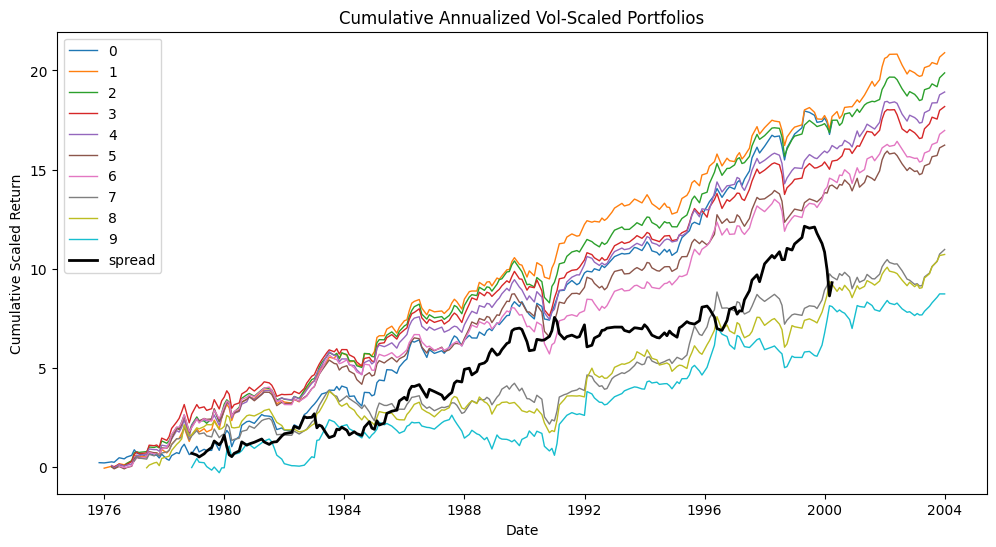

In [34]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()


In [35]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)


Sharpe ratios:
0    0.791167
1    0.876820
2    0.786395
3    0.746111
4    0.821285
5    0.769420
6    0.640408
7    0.449592
8    0.555364
9    0.599769
dtype: float32


In [36]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,0,1,2,3,4,5,6,7,8,9
const,-0.0008 (-0.57),-0.0011 (-0.84),-0.0022 (-1.57),-0.002 (-1.44),0.0007 (0.46),0.0 (0.01),-0.0008 (-0.38),-0.0053 (-2.5),-0.0007 (-0.19),0.0056 (0.95)
Mkt-RF,0.9673 (28.6),1.0813 (34.4),1.0522 (31.23),0.9941 (29.82),1.0795 (27.4),1.0943 (28.96),1.1119 (21.76),1.1113 (21.6),1.1802 (13.31),1.3062 (9.06)
SMB,0.0007 (0.02),0.3331 (8.48),0.6387 (14.99),0.7741 (18.38),0.8194 (16.49),0.9927 (20.81),1.1519 (17.79),1.27 (19.43),1.5881 (14.16),1.5864 (8.69)
HML,0.0936 (1.39),0.3303 (5.29),0.4005 (5.97),0.42 (6.34),0.2436 (3.11),0.3337 (4.45),0.2861 (2.82),0.3702 (3.61),0.4805 (2.72),0.61 (2.15)
RMW,0.3198 (5.69),0.4365 (8.36),0.4607 (8.22),0.3593 (6.48),0.3161 (4.84),0.1631 (2.6),0.1581 (1.87),-0.031 (-0.36),-0.2252 (-1.54),-0.6833 (-2.85)
CMA,0.0838 (0.84),0.0906 (0.98),-0.0386 (-0.39),-0.148 (-1.5),-0.0481 (-0.41),-0.0423 (-0.38),0.0804 (0.53),0.1329 (0.87),0.193 (0.74),0.1669 (0.4)


Monthly holding on failure in next 12 months

In [37]:
bin_names=[str(i) for i in range(10)]

in_sample=in_sample.filter(pl.col('p_failure_12').is_not_null())


in_sample=in_sample.with_columns(
    (pl.col('p_failure_12').qcut(10,labels=bin_names)).alias('bin')
)

rets=in_sample.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')

for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)




# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_2993521/751388965.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_2993521/751388965.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


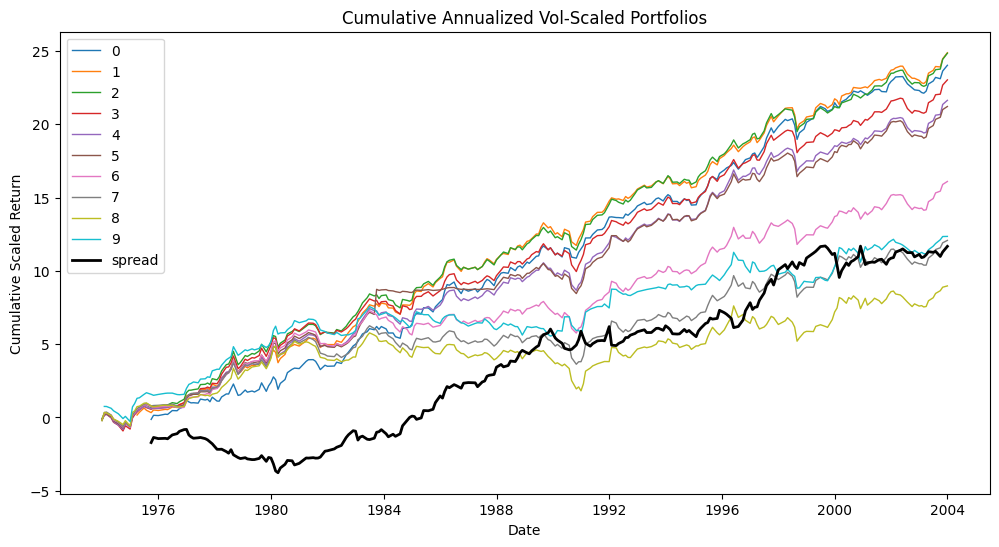

In [38]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [39]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)

# --- Average number of stocks per bin ---
n_stocks = (
    in_sample
    .group_by(["date","bin"])
    .agg(pl.count().alias("n"))
    .group_by("bin")
    .agg(pl.col("n").mean().alias("avg_n"))
    .sort("bin")
)

print("Average # of stocks per bin:")
print(n_stocks)


Sharpe ratios:
0    1.082000
1    1.038234
2    0.936228
3    0.837269
4    0.757080
5    0.493356
6    0.593731
7    0.417572
8    0.296686
9    0.557382
dtype: float32
Average # of stocks per bin:
shape: (10, 2)
┌─────┬────────────┐
│ bin ┆ avg_n      │
│ --- ┆ ---        │
│ cat ┆ f64        │
╞═════╪════════════╡
│ 0   ┆ 644.786667 │
│ 1   ┆ 612.139241 │
│ 2   ┆ 606.382445 │
│ 3   ┆ 612.136076 │
│ 4   ┆ 604.4875   │
│ 5   ┆ 604.4875   │
│ 6   ┆ 608.286164 │
│ 7   ┆ 606.382445 │
│ 8   ┆ 608.289308 │
│ 9   ┆ 612.139241 │
└─────┴────────────┘


/tmp/ipykernel_2993521/3645703563.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n"))


In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9
const,0.0004 (0.47),0.0013 (1.14),-0.0002 (-0.25),-0.0011 (-1.25),-0.0011 (-1.12),0.0034 (0.53),-0.0018 (-1.31),-0.004 (-2.49),-0.005 (-2.19),0.0045 (1.05)
Mkt-RF,0.8455 (44.58),0.8434 (29.39),0.8609 (38.95),0.9253 (42.35),0.97 (39.03),1.0369 (6.66),1.0142 (30.44),1.0667 (27.26),1.0687 (19.27),1.0264 (9.89)
SMB,0.2205 (9.15),0.3238 (9.03),0.4613 (16.63),0.6221 (22.75),0.7883 (25.3),0.9318 (4.77),1.0727 (25.67),1.2134 (24.68),1.4205 (20.41),1.7867 (13.77)
HML,0.1967 (5.2),0.1555 (2.68),0.1028 (2.28),0.1492 (3.37),0.154 (3.04),0.2236 (0.7),0.1963 (2.89),0.2073 (2.6),0.3388 (3.01),0.451 (2.15)
RMW,0.2681 (8.48),0.2859 (5.81),0.3003 (7.87),0.32 (8.53),0.3053 (7.12),0.3475 (1.29),0.1221 (2.12),-0.0352 (-0.52),-0.3055 (-3.21),-0.533 (-3.01)
CMA,0.1004 (1.79),0.2333 (2.81),0.3101 (4.82),0.2479 (3.91),0.2254 (3.12),0.1797 (0.4),0.0685 (0.71),-0.0573 (-0.5),-0.3676 (-2.28),-0.4717 (-1.57)


Different Size Bins

In [41]:
import polars as pl
import math

# keep only valid p_failure rows
in_sample = in_sample.filter(pl.col("p_failure").is_not_null())

# custom percentile cutpoints
probs = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 0.90, 0.95, 0.99]
qvals = (
    in_sample
    .select([pl.col("p_failure").quantile(p).alias(f"q{int(p*100)}") for p in probs])
).row(0)

# strictly increasing edges
edges = [-math.inf]
eps = 1e-12
for v in qvals:
    v = float(v)
    if v <= edges[-1]:
        v = edges[-1] + eps
    edges.append(v)
edges.append(math.inf)

bin_names = [
    "0-5","5-10","10-20","20-40","40-60",
    "60-80","80-90","90-95","95-99","99-100"
]

# assign bins via chained conditions (USE pl.lit for string outputs)
p = pl.col("p_failure")
expr = None
for i, label in enumerate(bin_names[:-1], start=1):  # up to the 9th edge
    cond = p <= edges[i]
    then_val = pl.lit(label)  # <- key fix
    expr = (pl.when(cond).then(then_val)) if expr is None else expr.when(cond).then(then_val)
expr = expr.otherwise(pl.lit(bin_names[-1]))

in_sample = in_sample.with_columns(expr.alias("bin"))


# --- 3) aggregate returns and cumulative series (your pipeline) ---
rets = (
    in_sample
    .group_by(["bin", "date"])
    .agg(pl.col("RET").mean())
    .sort(["bin", "date"])
    .pivot(index="date", on="bin", values="RET")
    .sort("date")
)

for b in bin_names:
    rets = rets.with_columns(pl.col(b).cum_sum().alias(f"{b}_cum"))


rets = rets.with_columns(
    (pl.col("0-5_cum") - pl.col("99-100_cum")).alias("spread_cum"),
    (pl.col("0-5") - pl.col("99-100")).alias("spread"),
)


In [42]:

# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])

/tmp/ipykernel_2993521/1056077454.py:10: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_2993521/1056077454.py:16: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


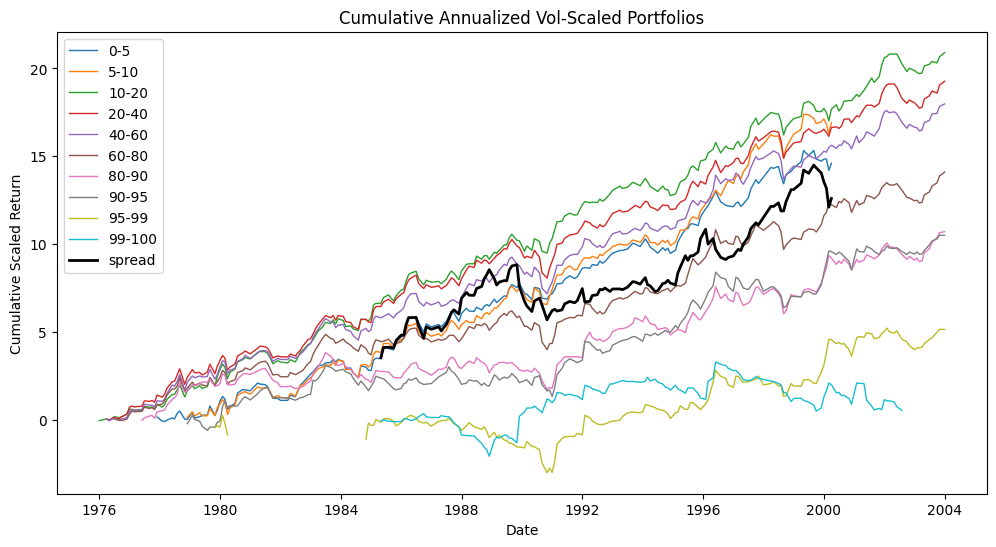

In [43]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0-5_vol_scaled_ann_cum", "99-100_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0-5_vol_scaled_ann_cum"]-sub["99-100_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_w_spread if defined)
try:
    bin_w_spread = [c for c in bin_w_spread if c in M.columns]
except NameError:
    bin_w_spread = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_w_spread] = M[bin_w_spread].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_w_spread:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0-5,5-10,10-20,20-40,40-60,60-80,80-90,90-95,95-99,99-100,spread
const,-0.0 (-0.02),-0.002 (-1.28),-0.0011 (-0.84),-0.0021 (-1.8),0.0006 (0.42),-0.0034 (-1.76),-0.0007 (-0.19),0.0061 (1.05),0.0016 (0.22),0.0077 (0.48),-0.0165 (-1.12)
Mkt-RF,0.9392 (22.82),0.9864 (26.52),1.0813 (34.4),1.0284 (35.77),1.0812 (32.44),1.1107 (23.81),1.1803 (13.31),1.317 (9.3),1.1292 (6.06),0.6127 (1.49),0.0644 (0.17)
SMB,-0.0607 (-1.13),0.0628 (1.33),0.3331 (8.48),0.7071 (19.44),0.9067 (21.57),1.195 (20.16),1.5878 (14.16),1.3911 (7.7),1.968 (8.29),2.456 (4.73),-2.4801 (-5.01)
HML,0.0016 (0.02),0.083 (1.13),0.3303 (5.29),0.4139 (7.23),0.2929 (4.42),0.3579 (3.85),0.4804 (2.72),0.3785 (1.35),1.4251 (3.92),0.5221 (0.65),-0.7249 (-0.95)
RMW,0.2076 (2.71),0.3979 (6.42),0.4365 (8.36),0.4079 (8.52),0.2176 (3.94),0.0104 (0.13),-0.2255 (-1.54),-0.6179 (-2.6),-0.7626 (-2.49),-0.8054 (-1.27),0.8349 (1.31)
CMA,0.237 (1.82),0.1003 (0.91),0.0906 (0.98),-0.0915 (-1.08),-0.035 (-0.36),0.1086 (0.79),0.1933 (0.74),0.4125 (1.0),-0.6216 (-1.17),-1.7859 (-1.56),1.2403 (1.11)


### Out of Sample

In [45]:
start=dt.date(2004,1,1)
end=dt.date(2024,12,31)

out_of_sample=data.filter(pl.col('date').is_between(start,end))

In [46]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -29.67,
 'tlmta_w': 3.36,
 'rsize_w': 0.082,
 'exretavg_w': -7.35,
 'sigma_w': 1.48,
 'cshmta_w': -2.40,
 'log_prc_w':-0.937,
 'mbq_w':.054
 }

b0_exact = -9.08

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in out_of_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
out_of_sample = out_of_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure")
)


In [47]:
# 1) grab coefficients from statsmodels
betas_exact = {'nimtaavg_w': -20.26,
 'tlmta_w': 1.42,
 'rsize_w': -0.045,
 'exretavg_w': -7.13,
 'sigma_w': 1.41,
 'cshmta_w': -2.13,
 'log_prc_w':-0.058,
 'mbq_w':.075
 }

b0_exact = -9.16

# 2) build the linear predictor in Polars
linpred = pl.lit(b0_exact)
for name, coef in betas_exact.items():
    # skip any coef whose column isn't present (defensive)
    if name in out_of_sample.columns:
        linpred = linpred + pl.col(name) * float(coef)

# 3) logistic transform to get probability for every row
out_of_sample = out_of_sample.with_columns(
    ((pl.lit(1.0) / (pl.lit(1.0) + (-linpred).exp())).shift(1)).alias("p_failure_12")
)


#### Portfolio Formation

In [48]:
ff5=pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/ff5.csv')

# ff5["date"] is like 196307 → make it the last calendar day of that month
ff5 = ff5.with_columns(
    (
        pl.concat_str([pl.col("date").cast(pl.Utf8), pl.lit("01")])  # "19630701"
        .str.strptime(pl.Date, format="%Y%m%d")                        # 1963-07-01
        .dt.offset_by("1mo")                                        # 1963-08-01
        .dt.replace(day=1)                                          # 1963-08-01 (idempotent)
        - pl.duration(days=1)                                       # 1963-07-31
    ).alias("date")
)



Monthly Rebalance (Equal Weight)

In [49]:
bin_names=[str(i) for i in range(10)]

decile1=out_of_sample.filter(pl.col('p_failure').is_not_null())


decile1=decile1.with_columns(
    (pl.col('p_failure').qcut(10,labels=bin_names)).alias('bin')
    
)

rets=decile1.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')


for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)


# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_2993521/147306125.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_2993521/147306125.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


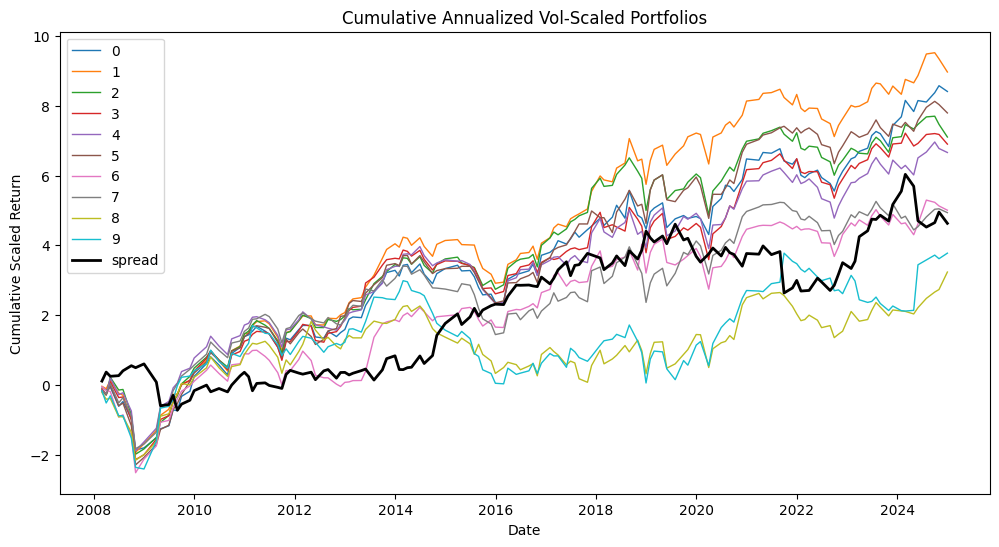

In [50]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()


In [51]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)


Sharpe ratios:
0    0.743478
1    0.760572
2    0.634863
3    0.611011
4    0.597851
5    0.679999
6    0.445942
7    0.411395
8    0.311551
9    0.350820
dtype: float32


In [52]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9
const,0.0022 (1.39),0.002 (1.48),0.0002 (0.16),0.0001 (0.06),-0.0006 (-0.34),0.0018 (0.97),-0.0021 (-0.93),-0.0017 (-0.61),-0.0017 (-0.39),0.0029 (0.31)
Mkt-RF,0.7662 (20.1),0.8725 (27.04),0.908 (30.63),0.9611 (27.92),0.9953 (24.51),1.0168 (23.2),1.1029 (19.76),1.0673 (16.11),1.1079 (10.25),1.5065 (6.55)
SMB,0.4033 (5.99),0.5718 (10.03),0.4255 (8.13),0.403 (6.63),0.4616 (6.44),0.5084 (6.57),0.551 (5.59),0.6003 (5.13),0.7406 (3.88),1.2885 (3.17)
HML,-0.2218 (-3.32),-0.1278 (-2.26),0.0095 (0.18),0.022 (0.37),0.0353 (0.5),0.1192 (1.55),0.3176 (3.25),0.1913 (1.65),0.1951 (1.03),0.4946 (1.23)
RMW,-0.1308 (-1.55),0.0592 (0.83),-0.0641 (-0.98),-0.1142 (-1.5),0.089 (0.99),-0.0852 (-0.88),-0.0413 (-0.33),-0.2316 (-1.58),-0.4574 (-1.91),-0.6428 (-1.26)
CMA,0.0706 (0.65),-0.0296 (-0.32),-0.0442 (-0.53),-0.0393 (-0.4),-0.0917 (-0.8),0.0373 (0.3),-0.1374 (-0.87),-0.0439 (-0.23),0.1139 (0.37),-0.5739 (-0.88)


Monthly holding on failure in next 12 months

In [53]:
bin_names=[str(i) for i in range(10)]

out_of_sample=out_of_sample.filter(pl.col('p_failure_12').is_not_null())


out_of_sample=out_of_sample.with_columns(
    (pl.col('p_failure_12').qcut(10,labels=bin_names)).alias('bin')
)

rets=out_of_sample.group_by(['bin','date']).agg(pl.col('RET').mean()).sort('bin','date')

rets=rets.pivot(index='date',on='bin',values='RET')
rets=rets.sort('date')

for bin in bin_names:
    rets=rets.with_columns(
        (pl.col(f'{bin}').cum_sum()).alias(f'{bin}_cum')
    )

rets=rets.with_columns(
    (pl.col('0_cum')-pl.col('9_cum')).alias('spread_cum')
)

rets=rets.with_columns(
    (pl.col('0')-pl.col('9')).alias('spread')
)




# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])


/tmp/ipykernel_2993521/3593363874.py:40: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_2993521/3593363874.py:46: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


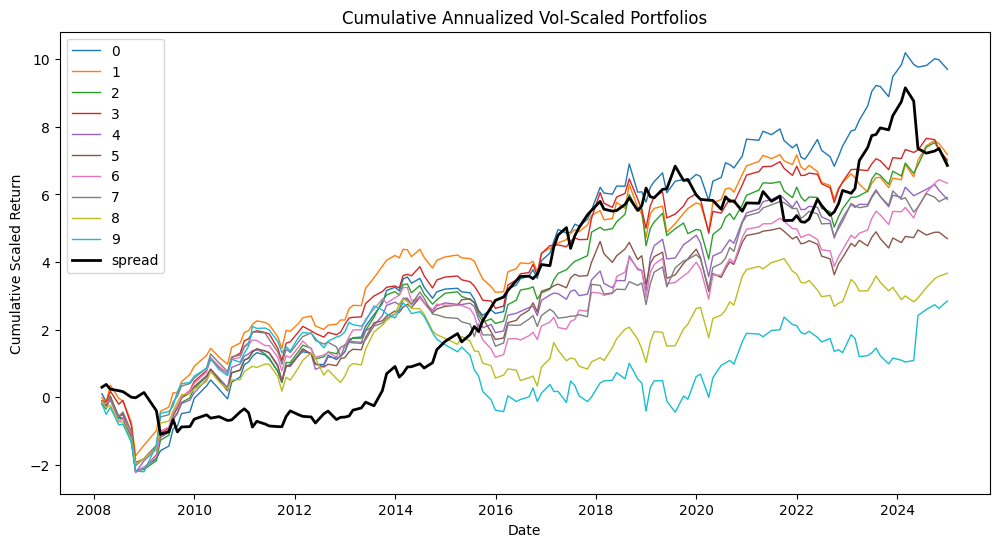

In [54]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0_vol_scaled_ann_cum", "9_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0_vol_scaled_ann_cum"]-sub["9_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [55]:
# --- Sharpe ratios per bin ---
rets_pd = rets.to_pandas().set_index("date")

bin_cols = [str(i) for i in range(10)]
rets_bins = rets_pd[bin_cols]

rf = 0.0  # set monthly risk-free if available
excess = rets_bins - rf

mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)   # annualized Sharpe (monthly → yearly)

print("Sharpe ratios:")
print(sharpe)

# --- Average number of stocks per bin ---
n_stocks = (
    in_sample
    .group_by(["date","bin"])
    .agg(pl.count().alias("n"))
    .group_by("bin")
    .agg(pl.col("n").mean().alias("avg_n"))
    .sort("bin")
)

print("Average # of stocks per bin:")
print(n_stocks)


Sharpe ratios:
0    0.823610
1    0.647431
2    0.670800
3    0.589629
4    0.511432
5    0.443813
6    0.604979
7    0.414920
8    0.327805
9    0.313393
dtype: float32
Average # of stocks per bin:
shape: (10, 2)
┌────────┬────────────┐
│ bin    ┆ avg_n      │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ 0-5    ┆ 85.659259  │
│ 10-20  ┆ 163.438163 │
│ 20-40  ┆ 315.723549 │
│ 40-60  ┆ 310.42953  │
│ 5-10   ┆ 85.655556  │
│ 60-80  ┆ 315.723549 │
│ 80-90  ┆ 167.583333 │
│ 90-95  ┆ 87.602273  │
│ 95-99  ┆ 70.888889  │
│ 99-100 ┆ 19.764957  │
└────────┴────────────┘


/tmp/ipykernel_2993521/3645703563.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n"))


In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9
const,0.0032 (1.93),0.0002 (0.14),0.0004 (0.31),-0.0005 (-0.38),-0.0014 (-0.94),-0.0023 (-1.28),0.001 (0.46),-0.0016 (-0.56),-0.0012 (-0.29),-0.0002 (-0.02)
Mkt-RF,0.7888 (19.76),0.8802 (25.08),0.8743 (25.91),0.9384 (27.03),0.996 (28.12),1.0389 (23.66),1.0437 (20.69),1.0323 (15.05),1.1338 (11.25),1.4962 (7.6)
SMB,0.2244 (3.18),0.5211 (8.41),0.4107 (6.89),0.4663 (7.61),0.4193 (6.7),0.3927 (5.06),0.4777 (5.36),0.7317 (6.04),0.8429 (4.74),1.2659 (3.64)
HML,-0.105 (-1.5),-0.0372 (-0.61),-0.0027 (-0.05),0.0716 (1.18),0.0824 (1.33),0.1751 (2.28),0.123 (1.39),0.2075 (1.73),0.1458 (0.83),0.35 (1.02)
RMW,-0.2144 (-2.42),0.0934 (1.2),0.0405 (0.54),0.0279 (0.36),-0.1217 (-1.55),-0.1291 (-1.33),-0.1771 (-1.58),-0.1187 (-0.78),-0.5738 (-2.57),-0.5621 (-1.29)
CMA,-0.0143 (-0.13),0.0129 (0.13),-0.0235 (-0.25),0.0023 (0.02),-0.0172 (-0.17),0.0201 (0.16),-0.1811 (-1.27),-0.067 (-0.35),-0.0119 (-0.04),-0.5149 (-0.92)


Different Size Bins

In [57]:
import polars as pl
import math

# keep only valid p_failure rows
out_of_sample = out_of_sample.filter(pl.col("p_failure").is_not_null())

# custom percentile cutpoints
probs = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 0.90, 0.95, 0.99]
qvals = (
    out_of_sample
    .select([pl.col("p_failure").quantile(p).alias(f"q{int(p*100)}") for p in probs])
).row(0)

# strictly increasing edges
edges = [-math.inf]
eps = 1e-12
for v in qvals:
    v = float(v)
    if v <= edges[-1]:
        v = edges[-1] + eps
    edges.append(v)
edges.append(math.inf)

bin_names = [
    "0-5","5-10","10-20","20-40","40-60",
    "60-80","80-90","90-95","95-99","99-100"
]

# assign bins via chained conditions (USE pl.lit for string outputs)
p = pl.col("p_failure")
expr = None
for i, label in enumerate(bin_names[:-1], start=1):  # up to the 9th edge
    cond = p <= edges[i]
    then_val = pl.lit(label)  # <- key fix
    expr = (pl.when(cond).then(then_val)) if expr is None else expr.when(cond).then(then_val)
expr = expr.otherwise(pl.lit(bin_names[-1]))

out_of_sample = out_of_sample.with_columns(expr.alias("bin"))


# --- 3) aggregate returns and cumulative series (your pipeline) ---
rets = (
    out_of_sample
    .group_by(["bin", "date"])
    .agg(pl.col("RET").mean())
    .sort(["bin", "date"])
    .pivot(index="date", on="bin", values="RET")
    .sort("date")
)

for b in bin_names:
    rets = rets.with_columns(pl.col(b).cum_sum().alias(f"{b}_cum"))


rets = rets.with_columns(
    (pl.col("0-5_cum") - pl.col("99-100_cum")).alias("spread_cum"),
    (pl.col("0-5") - pl.col("99-100")).alias("spread"),
)


In [58]:

# --- config ---
lookback = 36  # trailing months for rolling vol; change to 12/24/etc as you like
bin_w_spread = bin_names + ["spread"]

# --- 1) add rolling monthly vol and annualized vol for each series ---
rets = rets.with_columns(
    [
        # monthly rolling std
        pl.col(b)
        .rolling_std(window_size=lookback, min_periods=lookback)
        .alias(f"{b}_vol_m")
        for b in bin_w_spread
    ] + [
        # annualized rolling std = monthly std * sqrt(12)
        (
            pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)
            * (12 ** 0.5)
        ).alias(f"{b}_vol_ann")
        for b in bin_w_spread
    ]
)

# --- 2) (optional) create vol-scaled returns ---
# scaled by monthly vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_m") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_m"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_m")
    for b in bin_w_spread
])

# scaled by annualized vol (time-varying)
rets = rets.with_columns([
    pl.when(pl.col(f"{b}_vol_ann") > 0)
      .then(pl.col(b) / pl.col(f"{b}_vol_ann"))
      .otherwise(None)
      .alias(f"{b}_vol_scaled_ann")
    for b in bin_w_spread
])

/tmp/ipykernel_2993521/1056077454.py:10: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_std(window_size=lookback, min_periods=lookback)
/tmp/ipykernel_2993521/1056077454.py:16: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col(b).rolling_std(window_size=lookback, min_periods=lookback)


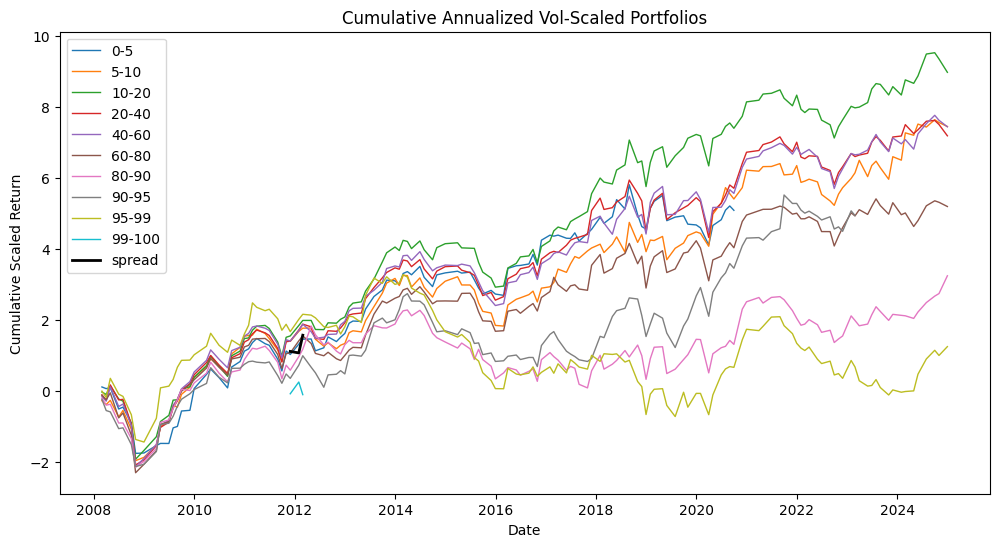

In [59]:
# --- compute cumulative annualized vol-scaled returns ---
bin_w_spread = bin_names + ["spread"]

for b in bin_w_spread:
    rets = rets.with_columns(
        pl.col(f"{b}_vol_scaled_ann").cum_sum().alias(f"{b}_vol_scaled_ann_cum")
    )

# --- plot cumulative annualized vol-scaled returns ---
plt.figure(figsize=(12, 6))
for b in bin_w_spread:
    cols = {f"{b}_vol_scaled_ann_cum", "date", "0-5_vol_scaled_ann_cum", "99-100_vol_scaled_ann_cum"}
    sub = rets.select(cols).to_pandas()
    x = sub["date"]
    y = sub[f"{b}_vol_scaled_ann_cum"]
    if b == "spread":
        y=sub["0-5_vol_scaled_ann_cum"]-sub["99-100_vol_scaled_ann_cum"]
        plt.plot(x, y, label=f"{b}", linewidth=2, color="black")
    else:
        plt.plot(x, y, label=f"{b}", linewidth=1)

plt.title("Cumulative Annualized Vol-Scaled Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Scaled Return")
plt.legend()
plt.show()

In [60]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = rets.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_w_spread if defined)
try:
    bin_w_spread = [c for c in bin_w_spread if c in M.columns]
except NameError:
    bin_w_spread = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_w_spread] = M[bin_w_spread].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_w_spread:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"

# Optional: quick diagnostics
print("Skipped portfolios:", skipped)

table


Skipped portfolios: {}


,0-5,5-10,10-20,20-40,40-60,60-80,80-90,90-95,95-99,99-100,spread
const,0.0038 (1.93),0.0011 (0.57),0.002 (1.48),0.0001 (0.12),0.0004 (0.3),-0.0023 (-1.22),-0.0017 (-0.39),0.0068 (0.93),-0.0102 (-1.21),0.137 (0.75),-0.1358 (-0.74)
Mkt-RF,0.7204 (14.97),0.8274 (16.95),0.8726 (27.04),0.9371 (35.57),0.9995 (28.01),1.093 (23.94),1.1079 (10.25),1.1927 (6.73),1.6483 (8.13),2.9049 (0.67),-2.2468 (-0.51)
SMB,0.41 (4.84),0.4334 (5.03),0.5718 (10.03),0.4117 (8.85),0.4823 (7.65),0.5474 (6.79),0.7406 (3.88),0.9192 (2.93),1.4288 (3.99),4.2607 (0.55),-3.8563 (-0.49)
HML,-0.1588 (-1.9),-0.3149 (-3.68),-0.1278 (-2.26),0.0063 (0.14),0.0795 (1.27),0.2658 (3.32),0.1951 (1.03),0.08 (0.26),0.3875 (1.09),4.7896 (0.64),-4.9682 (-0.66)
RMW,-0.1884 (-1.78),-0.1043 (-0.96),0.0592 (0.83),-0.0798 (-1.37),0.0136 (0.17),-0.1422 (-1.4),-0.4574 (-1.91),-0.8641 (-2.22),-0.8131 (-1.81),8.6441 (0.91),-8.8368 (-0.93)
CMA,-0.0705 (-0.52),0.2857 (2.07),-0.0296 (-0.32),-0.037 (-0.5),-0.0356 (-0.35),-0.0866 (-0.67),0.1139 (0.37),0.2906 (0.59),-0.3381 (-0.59),-16.7191 (-1.37),16.6163 (1.35)


### MVO backtest

In [59]:
start=dt.date(2024,1,1)
end=dt.date(2024,12,31)

barra_data=sfd.assets.load_assets(start=start,end=end,in_universe=True,columns=['date','historical_beta','ticker','price','return','barrid','cusip','specific_return','specific_risk','market_cap','total_risk','predicted_beta'])
barra_data=barra_data.rename({'cusip':'CUSIP'})
barra_data = barra_data.with_columns(
    pl.col("CUSIP").str.slice(0, 8).alias("CUSIP")
)


Merge out_of_sample with barra_data

In [60]:
out=out_of_sample.join(barra_data,on=['date','CUSIP'],how='right')

Make the alphas

In [61]:
#score the signal

out=out.with_columns(
    (((pl.col('p_failure'))-(pl.col('p_failure').mean()))/(pl.col('p_failure').std()*-1))
    .alias('p_failure_score')
)

out=out.with_columns(
    (((pl.col('p_failure_12'))-(pl.col('p_failure_12').mean()))/(pl.col('p_failure_12').std()*-1))
    .alias('p_failure_12_score')
)

In [62]:
IC=.05

out=out.with_columns(
    ((pl.col('p_failure_score'))*IC*(pl.col('specific_risk')/100)).alias('1_y_alpha')
)

out=out.with_columns(
    ((pl.col('p_failure_12_score'))*IC*(pl.col('specific_risk')/100)).alias('1_mo_alpha')
)




In [63]:
#get rid of out duplicates
out_dedup = out.unique(subset=["barrid", "date"], keep="first")


In [64]:
alpha1m=out_dedup
alpha1y=out_dedup

alpha1m=alpha1m.select(['date','barrid','1_mo_alpha','predicted_beta'])
alpha1y=alpha1y.select(['date','barrid','1_y_alpha','predicted_beta'])

alpha1m=alpha1m.rename({'1_mo_alpha':'alpha'})
alpha1y=alpha1y.rename({'1_y_alpha':'alpha'})

alpha1m=alpha1m.with_columns(
    (pl.col('alpha').fill_null(0)).alias('alpha')
)

alpha1y=alpha1y.with_columns(
    (pl.col('alpha').fill_null(0)).alias('alpha')
)

In [56]:
mkt_cap=out.select(['market_cap','barrid','date','rsize','meq','totval'])
mkt_cap=mkt_cap.with_columns(
    (((pl.col('market_cap')/1000)*13)/pl.col('totval')).alias('signal_weight')
)



In [57]:
alpha1m_vw=alpha1m.join(mkt_cap,on=['barrid','date'])
alpha1m_vw=alpha1m_vw.with_columns(
    ((pl.col('alpha'))*pl.col('signal_weight')).alias('alpha')
)

alpha1m_vw = alpha1m_vw.unique(subset=["barrid", "date"], keep="first")
alpha1m_vw=alpha1m_vw.select(['date','barrid','alpha','predicted_beta'])

In [58]:
alpha1y_vw=alpha1y.join(mkt_cap,on=['barrid','date'])
alpha1y_vw=alpha1y_vw.with_columns(
    ((pl.col('alpha'))*pl.col('signal_weight')).alias('alpha')
)

alpha1y_vw = alpha1y_vw.unique(subset=["barrid", "date"], keep="first")
alpha1y_vw=alpha1y_vw.select(['date','barrid','alpha','predicted_beta'])

**Do the backests**

In [71]:
out.filter(pl.col('1_y_alpha').is_not_null())

PERMNO,SHRCD,EXCHCD,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,RETX,NCUSIP,TICKER,DLAMT,DLPDT,DLSTCD,DLRETX,DLPRC,DLRET,costat,curcdq,datafmt,indfmt,consol,gvkey,cusip,atq,cheq,ltq,niq,pstkrq,seqq,txditcq,LINKTYPE,LPERMCO,LINKDT,LINKENDDT,tic,…,tlta,sigma,exretavg,nimtaavg,prc_winsor,log_prc,nita_w,tlta_w,exret_w,sigma_w,rsize_w,log_prc_w,nimtaavg_w,exretavg_w,mbq_w,tlmta_w,cshmta_w,failure,p_failure,p_failure_12,bin,date,historical_beta,ticker,price,return,barrid,CUSIP,specific_return,specific_risk,market_cap,total_risk,predicted_beta,p_failure_score,p_failure_12_score,1_y_alpha,1_mo_alpha
i64,i64,i64,f64,f64,f64,i64,f32,i64,str,str,str,f64,str,i64,str,f64,f32,str,str,str,str,str,i64,str,f64,f64,f64,f64,f64,f64,f64,str,i64,str,str,str,…,f64,f32,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,i8,f64,f64,str,date,f64,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
13878,11,3,9.08,9.75,9.62,156447,0.04,146946,"""0.040000""","""60249610""","""MDXG""",0.0,null,100,"""A""",0.0,null,"""A""","""USD""","""STD""","""INDL""","""C""",178157,"""602496101""",263.915,104.416,70.808,7.438,0.0,193.107,0.0,"""LC""",54378,"""2020-11-04""","""E""","""MDXG""",…,0.171272,0.673215,-0.01817,-0.003538,9.62,2.263844,0.021511,0.259034,0.064528,0.673215,-10.510272,2.263844,-0.003538,-0.01817,7.809713,0.149518,0.060143,0,0.000062,0.000938,"""40-60""",2024-12-31,0.483153,"""MDXG""",9.62,1.4768,"""USA06Z1""","""60249610""",1.486,48.685366,1.4136e9,52.552874,0.712399,0.122269,-0.120935,0.002976,-0.002944
13878,11,3,9.08,9.75,9.62,156447,0.04,146946,"""0.040000""","""60249610""","""MDXG""",0.0,null,100,"""A""",0.0,null,"""A""","""USD""","""STD""","""INDL""","""C""",178157,"""602496101""",263.915,104.416,70.808,7.438,0.0,193.107,0.0,"""LC""",54378,"""2013-04-25""","""2018-11-07""","""MDXG""",…,0.575634,0.673215,-0.002545,-0.002263,9.62,2.263844,-0.034556,0.575634,0.064528,0.673215,-10.510272,2.263844,-0.002263,-0.002545,null,0.452193,null,0,0.000043,0.000913,"""40-60""",2024-12-31,0.483153,"""MDXG""",9.62,1.4768,"""USA06Z1""","""60249610""",1.486,48.685366,1.4136e9,52.552874,0.712399,0.176061,-0.099606,0.004286,-0.002425
89606,11,3,12.98,13.85,13.73,53005,0.051302,45569,"""0.051302""","""83175410""","""SWBI""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.512098,0.318393,-0.017257,-0.002222,13.73,2.619583,-0.011088,0.512098,-0.000399,0.318393,-11.170578,2.619583,-0.002222,-0.017257,null,0.346862,null,0,0.000019,0.000415,"""20-40""",2024-02-29,0.534924,"""SWBI""",13.73,1.8546,"""USA16A1""","""83175410""",1.674,31.521932,6.2663e8,38.163854,0.803738,0.244098,0.328581,0.003847,0.005179
89606,11,3,16.01,17.19,16.77,51817,-0.011785,45562,"""-0.011785""","""83175410""","""SWBI""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.567755,0.620089,-0.006529,-0.001519,15.0,2.70805,-0.022495,0.567755,-0.058759,0.620089,-11.005672,2.70805,-0.001519,-0.006529,null,0.350349,null,0,0.000021,0.000572,"""20-40""",2024-05-31,0.421273,"""SWBI""",16.77,3.3909,"""USA16A1""","""83175410""",2.087,33.584251,7.6332e8,39.201284,0.737078,0.238747,0.193616,0.004009,0.003251
89606,11,3,12.24,14.48,12.98,102673,-0.110583,44852,"""-0.119403""","""83175410""","""SWBI""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.601765,0.393129,0.01421,0.003958,12.98,2.56341,-0.013639,0.601765,-0.137185,0.393129,-11.371604,2.56341,0.003958,0.01421,null,0.393032,null,0,0.000015,0.000415,"""10-20""",2024-09-30,0.86288,"""SWBI""",12.98,-0.3837,"""USA16A1""","""83175410""",-0.578,33.068842,5.8218e8,42.186589,1.031753,0.256986,0.328624,0.004249,0.005434
89606,11,3,9.79,14.1,10.105,209571,-0.246318,44220,"""-0.255891""","""83175410""","""SWBI""",0.0,null,100,"""A""",0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null

1 month alpha

In [65]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment()]
# ,sfo.LongOnly()


month_alpha_bt=sfb.backtest_parallel(alpha1m,constraints=constraints,gamma=5,n_cpus=10)

2025-09-30 20:15:18,942	INFO worker.py:1951 -- Started a local Ray instance.
(pid=2821328) Computing portfolios with 10 cpus 0: 100%|██████████| 252/252 [12:45<00:00, 3.04s/it] 


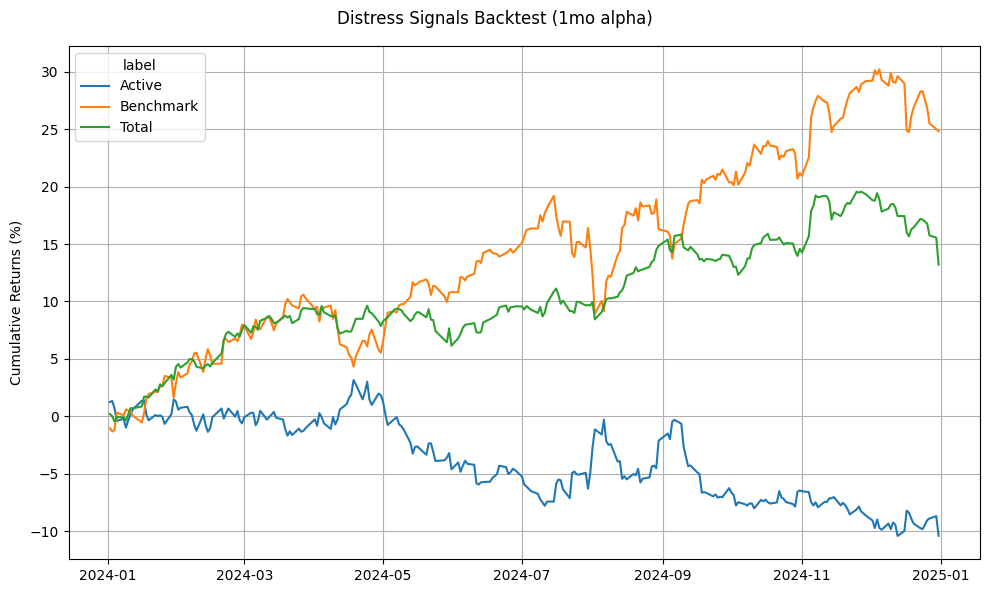

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",252,-10.31,11.65,-10.41,-0.89
"""Benchmark""",252,23.03,13.04,24.82,1.77
"""Total""",252,12.72,7.84,13.21,1.62


In [66]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1mo alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [67]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0005 (-0.12),-0.0076 (-5.7),-0.0039 (-1.19)
Mkt-RF,0.1775 (0.78),0.0729 (1.02),0.2534 (1.45)
SMB,0.0674 (0.28),-0.4157 (-5.39),-0.3608 (-1.91)
HML,-0.0352 (-0.09),0.4528 (3.8),0.4417 (1.51)
RMW,0.0083 (0.02),-0.3392 (-2.89),-0.3324 (-1.16)
CMA,0.7944 (1.14),-0.645 (-2.94),0.1249 (0.23)


1 month alpha different params

In [68]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment()]
# ,sfo.LongOnly()


month_alpha_bt=sfb.backtest_parallel(alpha1m,constraints=constraints,gamma=100,n_cpus=10)

2025-09-29 15:32:30,819	INFO worker.py:1951 -- Started a local Ray instance.
(pid=4185672) Computing portfolios with 10 cpus 0:  99%|█████████▉| 176/177 [01:23<00:01, 1.71s/it] 

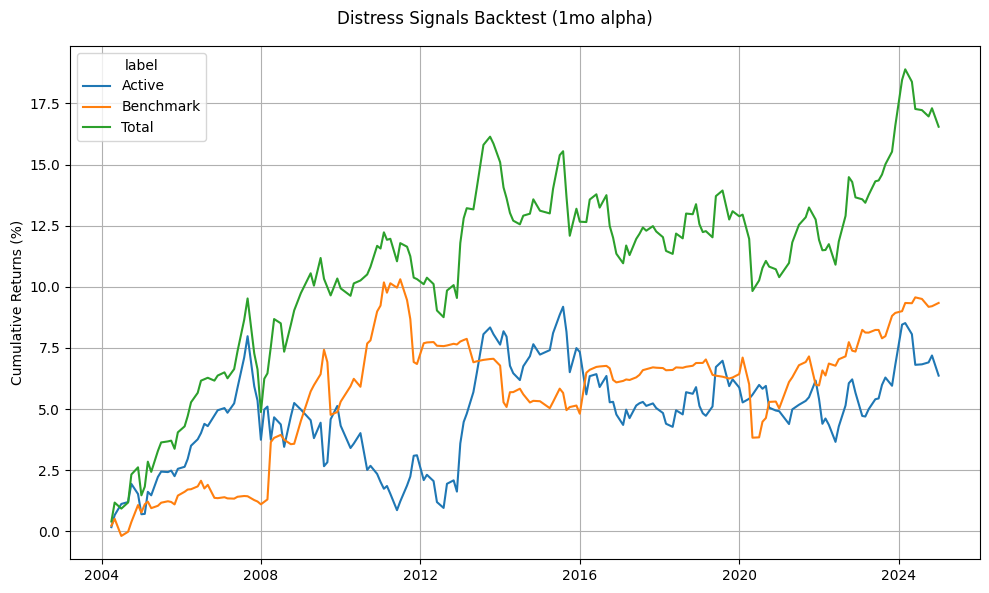

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,9.33,10.43,6.37,0.89
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,22.36,10.56,16.55,2.12


In [69]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1mo alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [70]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.51),-0.0008 (-1.85),-0.0002 (-0.42)
Mkt-RF,-0.0031 (-0.25),-0.0028 (-0.28),-0.0077 (-0.62)
SMB,-0.0105 (-0.48),0.0097 (0.55),-0.006 (-0.27)
HML,0.0012 (0.06),0.0155 (0.89),0.0191 (0.87)
RMW,-0.0497 (-1.8),-0.0083 (-0.38),-0.0569 (-2.06)
CMA,-0.0386 (-1.1),-0.0115 (-0.41),-0.0662 (-1.88)


1 month alpha different params again

In [71]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment(),sfo.LongOnly()]
# 


month_alpha_bt=sfb.backtest_parallel(alpha1m,constraints=constraints,gamma=5,n_cpus=10)

2025-09-29 15:36:08,850	INFO worker.py:1951 -- Started a local Ray instance.


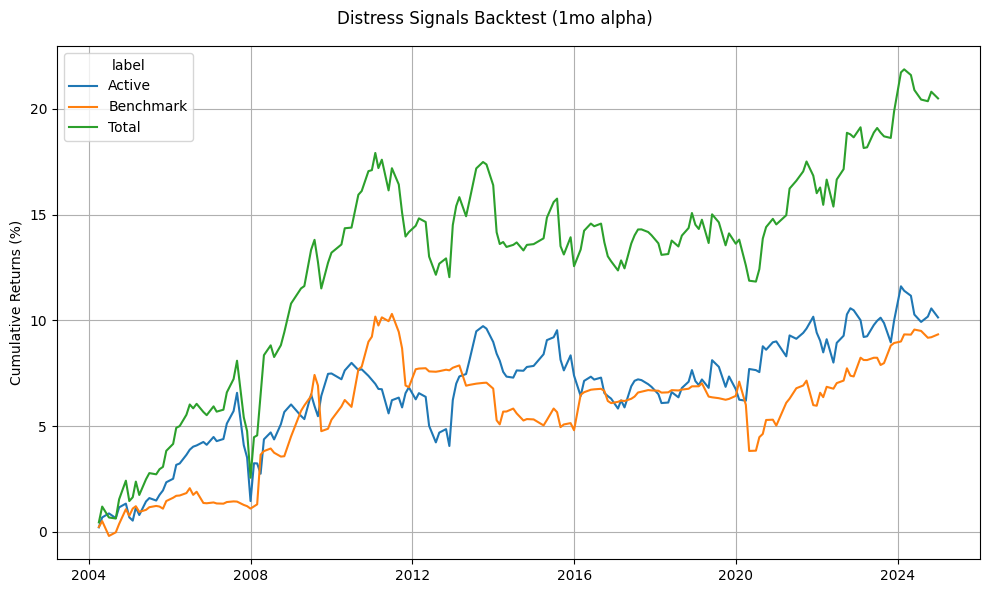

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,14.22,9.67,10.14,1.47
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,27.25,11.82,20.5,2.31


In [72]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1mo alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [73]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.67),-0.0008 (-1.85),-0.0003 (-0.43)
Mkt-RF,0.0123 (1.04),-0.0028 (-0.28),0.0077 (0.54)
SMB,0.0078 (0.37),0.0097 (0.55),0.0122 (0.48)
HML,-0.0101 (-0.49),0.0155 (0.89),0.0077 (0.31)
RMW,-0.0143 (-0.55),-0.0083 (-0.38),-0.0216 (-0.68)
CMA,-0.0152 (-0.46),-0.0115 (-0.41),-0.0428 (-1.06)


1 month alpha different params again

In [74]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment(),sfo.LongOnly()]
# 


month_alpha_bt=sfb.backtest_parallel(alpha1m,constraints=constraints,gamma=100,n_cpus=10)

2025-09-29 15:39:44,550	INFO worker.py:1951 -- Started a local Ray instance.





























































































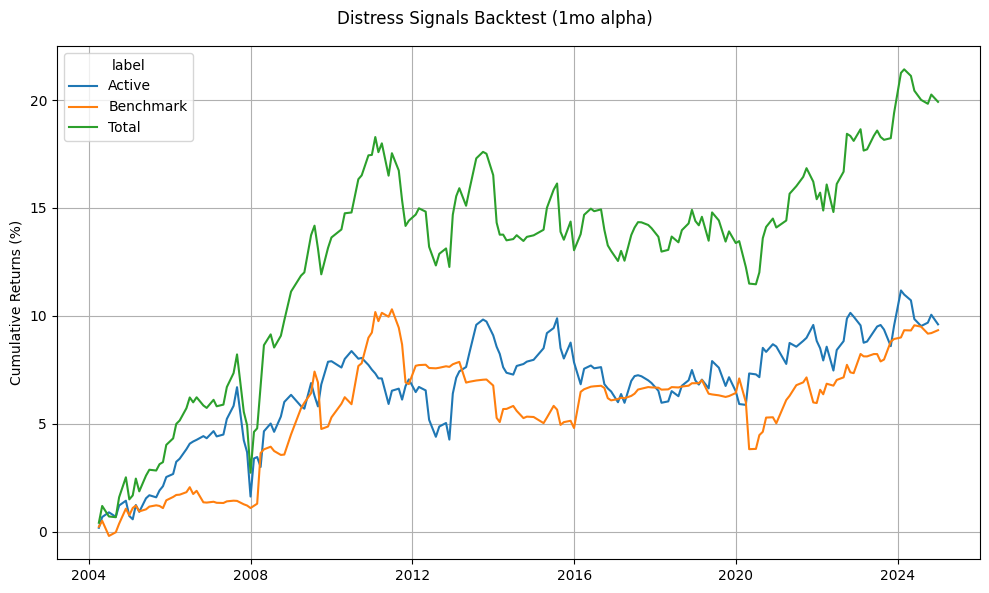

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,13.53,9.68,9.61,1.4
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,26.57,11.83,19.92,2.25


In [75]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1mo alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [76]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.72),-0.0008 (-1.85),-0.0003 (-0.47)
Mkt-RF,0.0111 (0.94),-0.0028 (-0.28),0.0065 (0.46)
SMB,0.0074 (0.35),0.0097 (0.55),0.0118 (0.47)
HML,-0.0101 (-0.49),0.0155 (0.89),0.0078 (0.31)
RMW,-0.0116 (-0.44),-0.0083 (-0.38),-0.0188 (-0.59)
CMA,-0.0175 (-0.52),-0.0115 (-0.41),-0.0451 (-1.11)


1 year alpha

In [82]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment() ,sfo.LongOnly()]



year_alpha_bt=sfb.backtest_parallel(alpha1y,constraints=constraints,gamma=3,n_cpus=10)

2025-09-26 22:12:12,775	INFO worker.py:1951 -- Started a local Ray instance.





























































































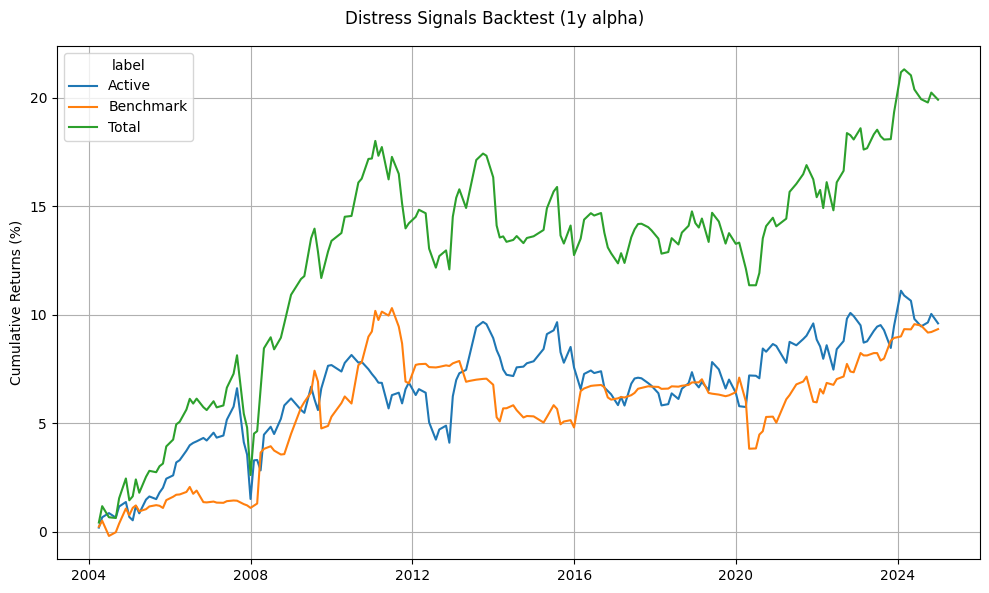

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,13.53,9.71,9.6,1.39
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,26.56,11.85,19.91,2.24


In [83]:
year_port_rets=sfp.generate_returns_from_weights(year_alpha_bt)

sfp.generate_returns_chart(year_port_rets,title='Distress Signals Backtest (1y alpha)')
sum_stats=sfp.generate_summary_table(year_port_rets)
sum_stats

In [84]:
month_ret_ff=year_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.72),-0.0008 (-1.85),-0.0003 (-0.47)
Mkt-RF,0.0117 (0.98),-0.0028 (-0.28),0.0071 (0.5)
SMB,0.0075 (0.36),0.0097 (0.55),0.0119 (0.47)
HML,-0.0101 (-0.48),0.0155 (0.89),0.0078 (0.31)
RMW,-0.0127 (-0.48),-0.0083 (-0.38),-0.02 (-0.63)
CMA,-0.0162 (-0.48),-0.0115 (-0.41),-0.0438 (-1.08)


year with higher gamma

In [77]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment() ,sfo.LongOnly()]



year_alpha_bt=sfb.backtest_parallel(alpha1y,constraints=constraints,gamma=1000,n_cpus=10)

2025-09-29 15:43:26,078	INFO worker.py:1951 -- Started a local Ray instance.
































































































































































































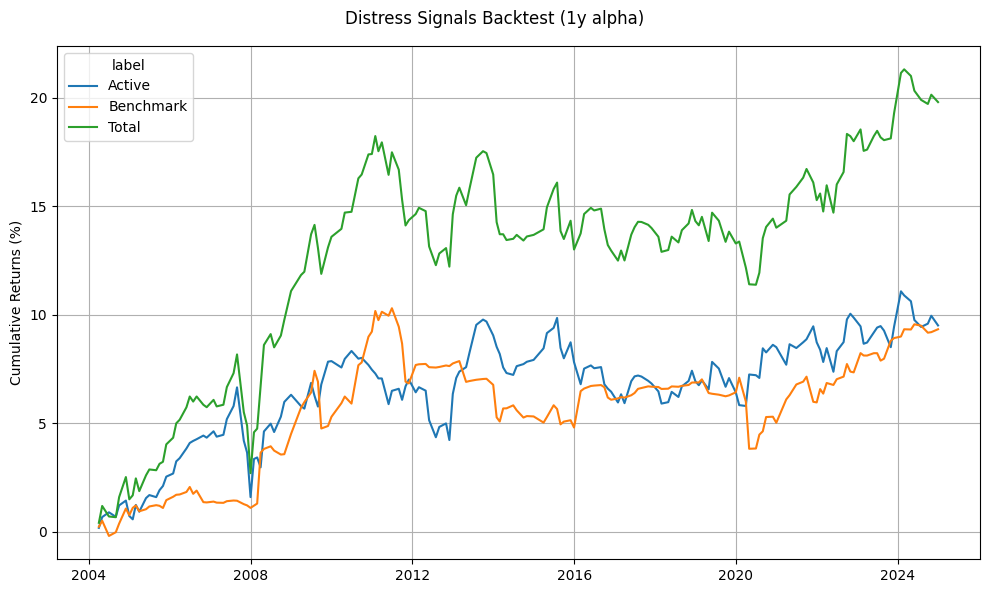

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,13.41,9.68,9.51,1.39
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,26.44,11.82,19.81,2.24


In [78]:
year_port_rets=sfp.generate_returns_from_weights(year_alpha_bt)

sfp.generate_returns_chart(year_port_rets,title='Distress Signals Backtest (1y alpha)')
sum_stats=sfp.generate_summary_table(year_port_rets)
sum_stats

In [79]:
month_ret_ff=year_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.73),-0.0008 (-1.85),-0.0003 (-0.48)
Mkt-RF,0.011 (0.93),-0.0028 (-0.28),0.0064 (0.45)
SMB,0.0076 (0.36),0.0097 (0.55),0.012 (0.48)
HML,-0.0102 (-0.49),0.0155 (0.89),0.0077 (0.31)
RMW,-0.0115 (-0.44),-0.0083 (-0.38),-0.0187 (-0.59)
CMA,-0.0173 (-0.52),-0.0115 (-0.41),-0.0449 (-1.11)


1 month alpha (value weighted)

In [73]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment()]
# ,sfo.LongOnly()


month_alpha_bt_vw=sfb.backtest_parallel(alpha1m_vw,constraints=constraints,gamma=5,n_cpus=10)

2025-09-26 08:43:39,727	INFO worker.py:1951 -- Started a local Ray instance.







































































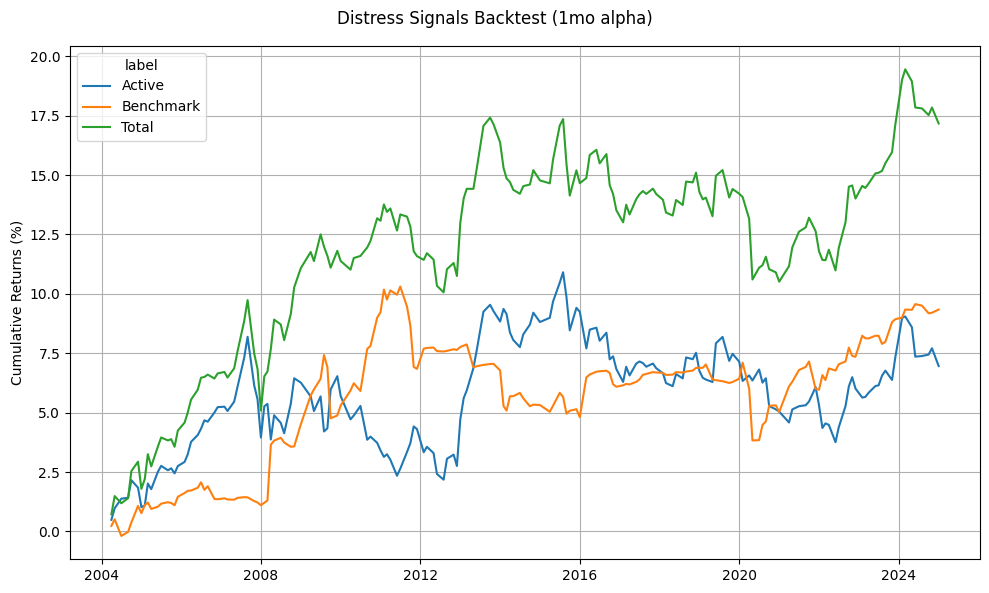

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,10.1,10.14,6.96,1.0
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,23.13,10.6,17.17,2.18


In [74]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt_vw)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1mo alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [75]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0007 (-1.43),-0.0008 (-1.85),-0.0002 (-0.3)
Mkt-RF,-0.008 (-0.66),-0.0028 (-0.28),-0.0125 (-1.0)
SMB,-0.0039 (-0.18),0.0097 (0.55),0.0005 (0.02)
HML,0.0018 (0.08),0.0155 (0.89),0.0196 (0.89)
RMW,-0.0449 (-1.67),-0.0083 (-0.38),-0.0521 (-1.87)
CMA,-0.0302 (-0.88),-0.0115 (-0.41),-0.0578 (-1.63)


Yearly VW

In [80]:
constraints=[sfo.NoBuyingOnMargin(),sfo.FullInvestment(),sfo.LongOnly()]
# ,sfo.LongOnly()


month_alpha_bt_vw=sfb.backtest_parallel(alpha1y_vw,constraints=constraints,gamma=1,n_cpus=10)

2025-09-29 15:46:58,949	INFO worker.py:1951 -- Started a local Ray instance.























































































































































































































































































































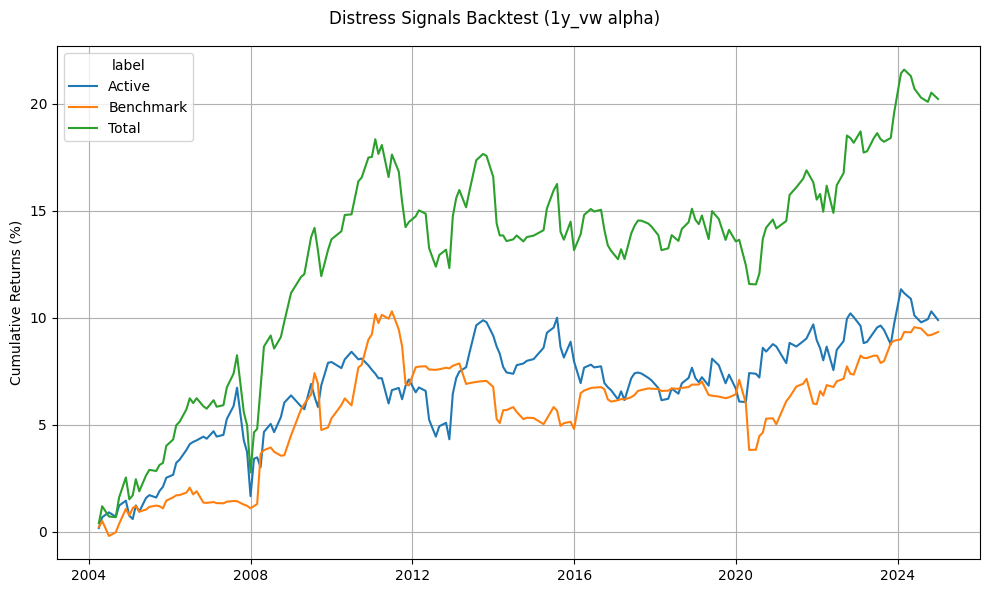

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",177,13.91,9.63,9.9,1.44
"""Benchmark""",177,13.03,7.99,9.34,1.63
"""Total""",177,26.94,11.8,20.23,2.28


In [81]:
month_port_rets=sfp.generate_returns_from_weights(month_alpha_bt_vw)

sfp.generate_returns_chart(month_port_rets,title='Distress Signals Backtest (1y_vw alpha)')
sum_stats=sfp.generate_summary_table(month_port_rets)
sum_stats

In [82]:
month_ret_ff=month_port_rets.pivot(index='date',values='return',on='portfolio')
bin_cols=['active','benchmark','total']

# --- to pandas ---
ff = ff5.to_pandas().copy()
rets_pd = month_ret_ff.to_pandas().copy()

# --- dates & indexing ---
ff["date"] = pd.to_datetime(ff["date"])          # your FF is month-end already
rets_pd["date"] = pd.to_datetime(rets_pd["date"])
ff = ff.set_index("date").sort_index()
rets_pd = rets_pd.set_index("date").sort_index()

# --- factor cleaning/scaling ---
factor_cols = ["Mkt-RF","SMB","HML","RMW","CMA","RF"]
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors="coerce")
# Scale % → decimals if needed
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0

# --- align on date ---
M = rets_pd.join(ff[factor_cols], how="inner")

# portfolio columns (or keep your existing bin_cols if defined)
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]

# ensure numeric
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors="coerce")
factors = M[["Mkt-RF","SMB","HML","RMW","CMA"]]

# --- regressions ---
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, "RF"]], factors], axis=1)
    tmp.columns = ["port", "RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    tmp["y"] = tmp["port"] - tmp["RF"]
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    if tmp.shape[0] <= 6:   # need > #params (const + 5 factors = 6)
        skipped[b] = f"not enough obs (n={tmp.shape[0]})"
        continue

    X = sm.add_constant(tmp[["Mkt-RF","SMB","HML","RMW","CMA"]], has_constant="add")
    y = tmp["y"]
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues

# --- results table ---
row_order = ["const","Mkt-RF","SMB","HML","RMW","CMA"]
coef_df  = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + " (" + tstat_df.round(2).astype(str) + ")"


table


,active,benchmark,total
const,-0.0008 (-1.7),-0.0008 (-1.85),-0.0003 (-0.45)
Mkt-RF,0.0106 (0.91),-0.0028 (-0.28),0.0061 (0.43)
SMB,0.0078 (0.38),0.0097 (0.55),0.0122 (0.49)
HML,-0.0105 (-0.51),0.0155 (0.89),0.0074 (0.3)
RMW,-0.0104 (-0.4),-0.0083 (-0.38),-0.0176 (-0.56)
CMA,-0.0178 (-0.53),-0.0115 (-0.41),-0.0454 (-1.12)
